In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
4  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   

                   sound_type                   source_url  \
0  adult, sex uncertain, song  //www.xeno-canto.org/557838   
1  adult, sex uncertain, song  //www.xeno-canto.org/557838   
2  adult, sex uncertain, song  //www.xeno-canto.org/557838   
3  adult, sex uncertain, song  //www.xeno-canto.org/557838   
4  adult, sex uncertain, song  //www.xeno-canto.org/557838   

                                        license   time        date  \
0  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
1  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
2  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
3  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
4  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   

                                             remarks      filename  
0  Recorded with Voice Record Pro on iPhone7, nor...  557838-0.wav  
1  Recorded with Voice Record Pro on iPhone7, nor...  557838-1.wav  
2  Recorded with Voice Record Pro on iPhone7, nor...  557838-4.wav  
3  Recorded with Voice Record Pro on iPhone7, nor...  557838-5.wav  
4  Recorded with Voice Record Pro on iPhone7, nor...  557838-6.wav

In [3]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [4]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [6]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [7]:
#load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [8]:
# Function to extract mfcc features
def extract_features(audio_clips, sr):
    mfcc_features = []
    for sound in audio_clips:
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_scaled)
    return np.array(mfcc_features)

# Variables
fixed_length = 5 * 22050  # 5 seconds multiplied by sampling rate
sr = 22050  # Default sampling rate from librosa


# Load and process audio files
processed_audio = load_and_process_audio(file_paths, sr, fixed_length)

# Extract features
features = extract_features(processed_audio, sr)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(features, y_encoded, file_paths, test_size=0.2, random_state=42)


In [9]:
# Initialize the model
clf_mfcc = RandomForestClassifier(random_state=42)

# Train the model
clf_mfcc.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_mfcc.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(f"Classification Report: {classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n")


Accuracy: 0.9013824884792627

Classification Report:               precision    recall  f1-score   support

    bewickii       0.91      0.89      0.90       193
  cardinalis       0.92      0.91      0.92       204
     melodia       0.87      0.92      0.89       243
 migratorius       0.90      0.96      0.93       207
 polyglottos       0.92      0.83      0.87       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085




The overall accuracy of the model is approximately 90.14%. Each bird species is evaluated on precision, recall, and F1-score, which are metrics indicating how well the model performs for each specific class. For instance, "Cardinalis cardinalis" has a precision of 0.92 and a recall of 0.91, resulting in an F1-score of 0.91, suggesting high accuracy and consistency in predicting this particular species. 

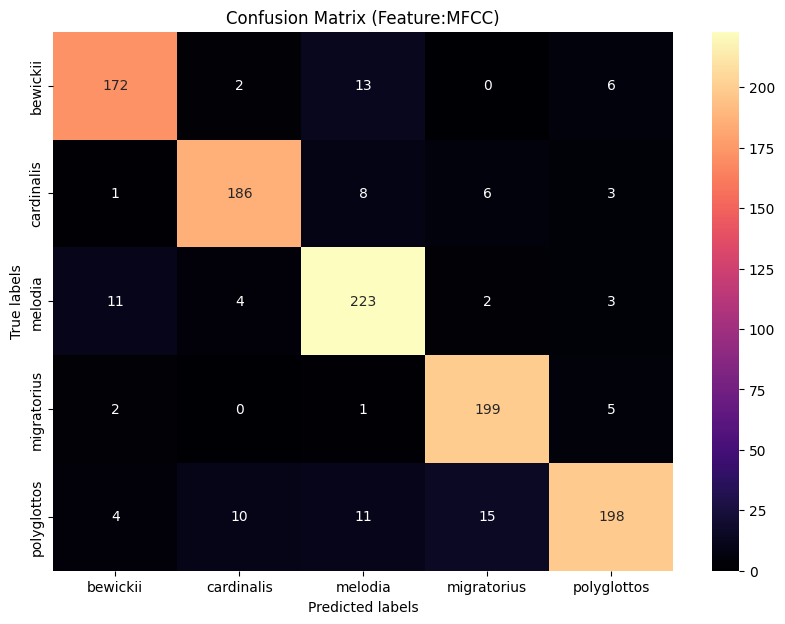

[[172   2  13   0   6]
 [  1 186   8   6   3]
 [ 11   4 223   2   3]
 [  2   0   1 199   5]
 [  4  10  11  15 198]]


In [10]:
cm_mfcc = confusion_matrix(y_test, y_pred)
# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mfcc, annot=True, fmt='g', cmap='magma', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Feature:MFCC)')
plt.show()
print(cm_mfcc)


In [11]:
# Function to plot MFCC coefficients
def plot_mfcc_coefficients(mfcc_features, title):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(mfcc_features)), mfcc_features)
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

In [12]:
mfcc_prob = clf_mfcc.predict_proba(X_test)
# Calculate the maximum confidence across classes for each sample
max_probs = np.max(mfcc_prob, axis=1)

# Get the indices of the top 10 most confident predictions
top_10_indices_mfcc = np.argsort(-max_probs)[:10]  
print(top_10_indices_mfcc )

[ 358 1052  408  208  220  237  328  781  393  281]


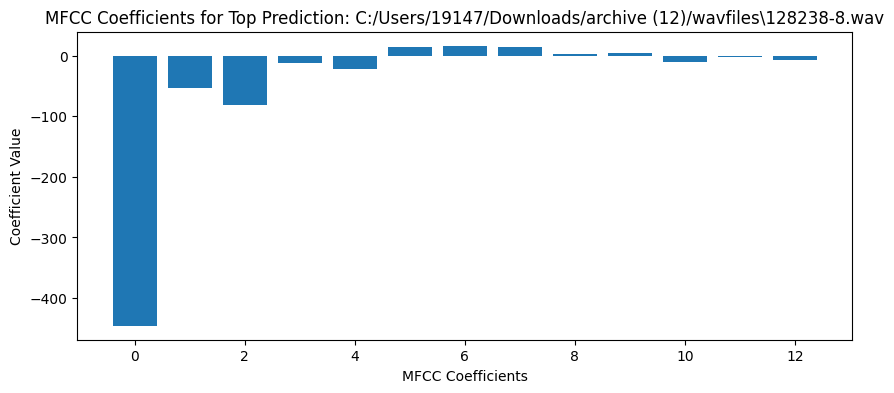

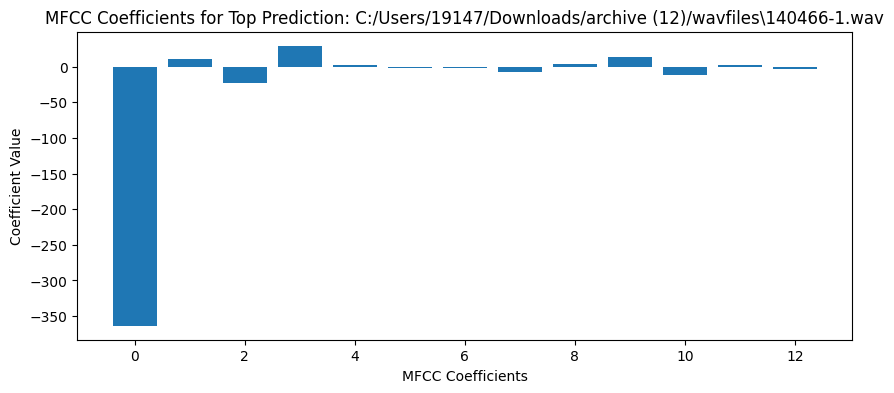

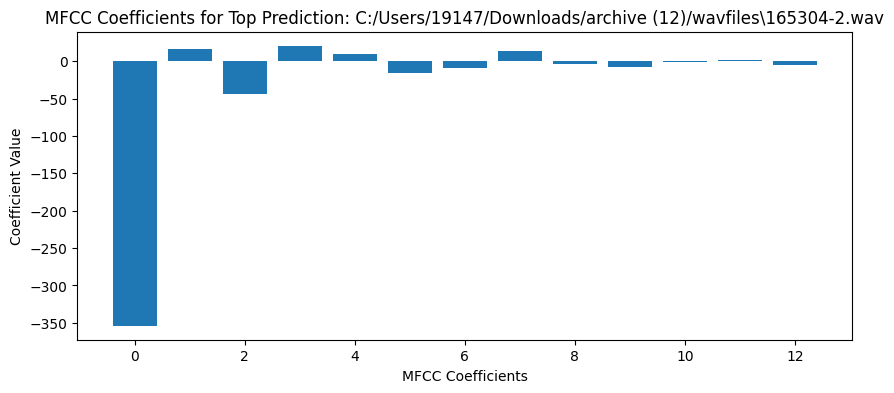

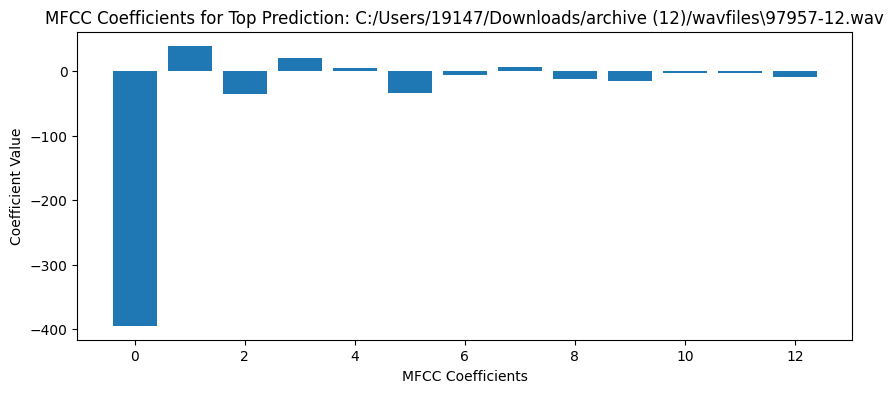

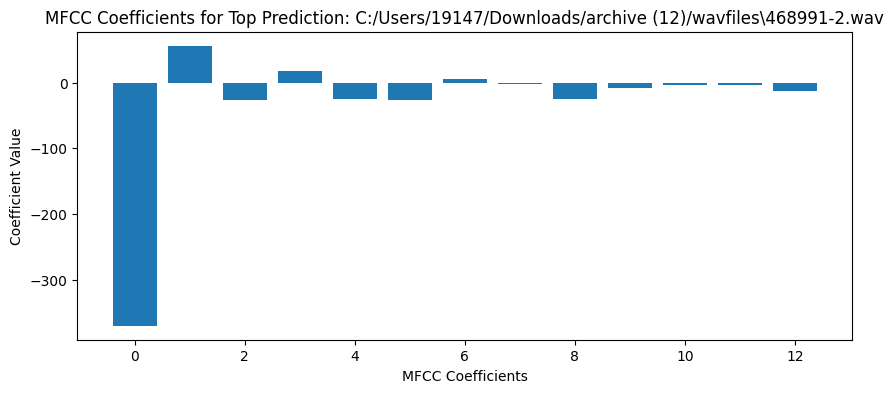

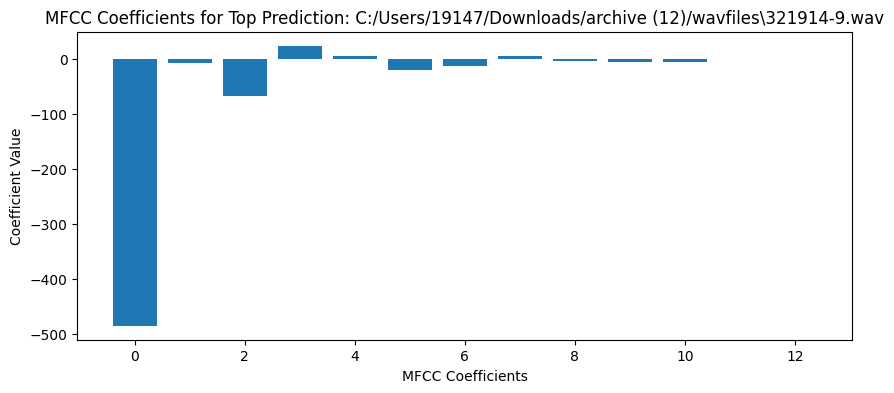

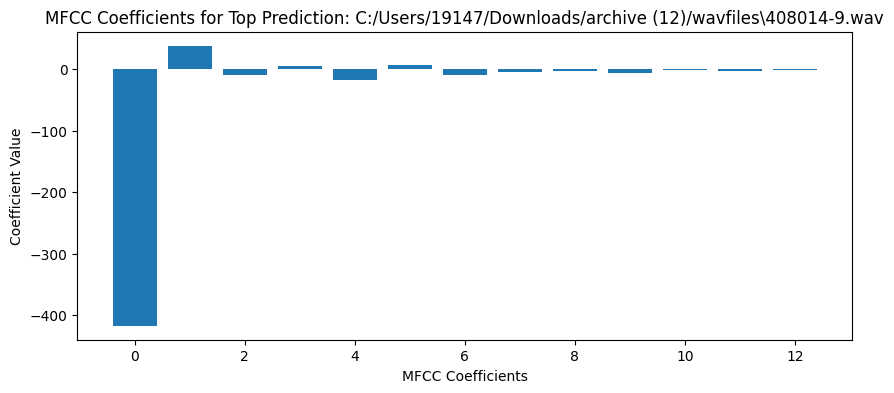

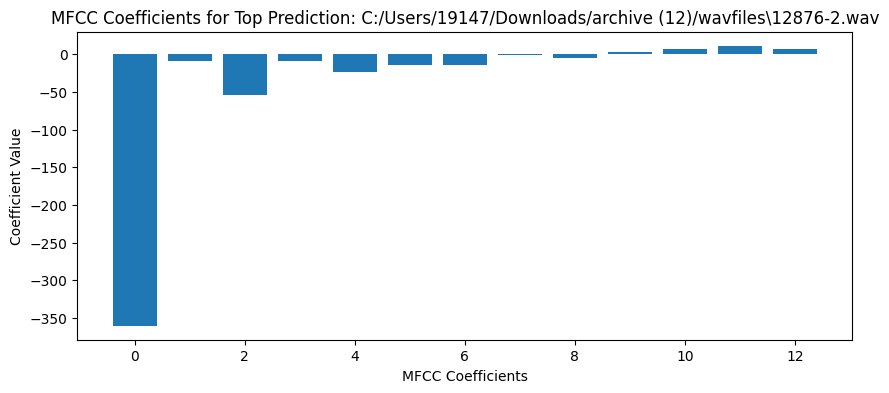

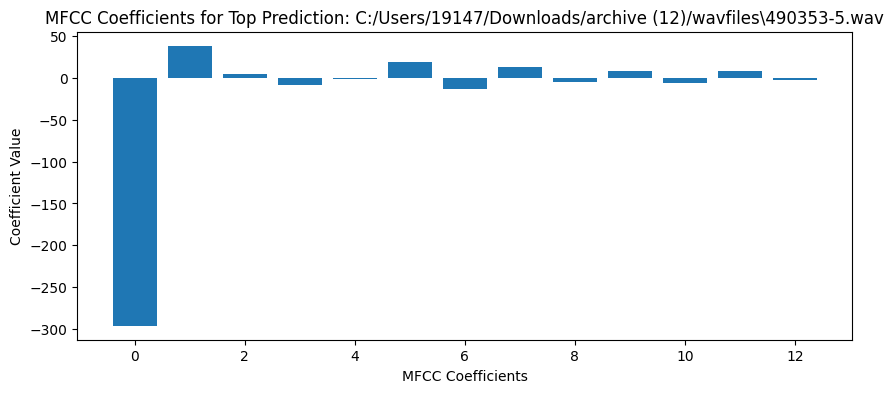

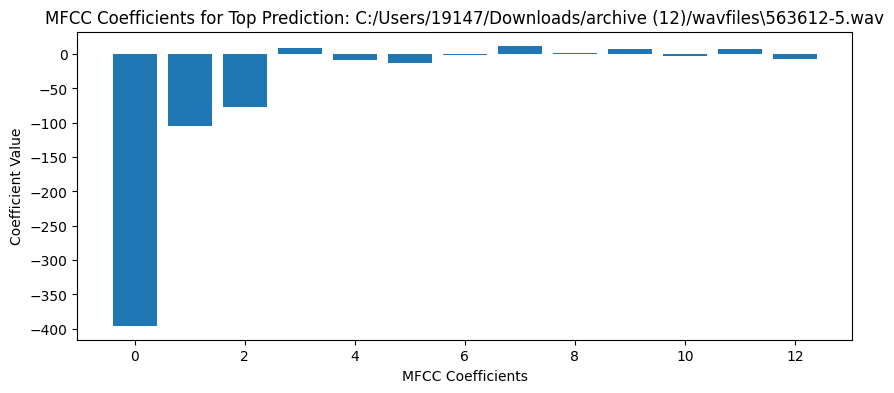

In [13]:
for index in top_10_indices_mfcc:
    most_confident_mfcc = X_test[index]
    most_confident_file_path = files_test[index]
    plot_mfcc_coefficients(most_confident_mfcc, f'MFCC Coefficients for Top Prediction: {most_confident_file_path}')

In [14]:
# Get the indices of the top 10 least confident predictions
bottom_10_indices_mfcc = np.argsort(max_probs)[:10]  
print(bottom_10_indices_mfcc)


[ 93  70 634 478 500 940 705  17 962 532]


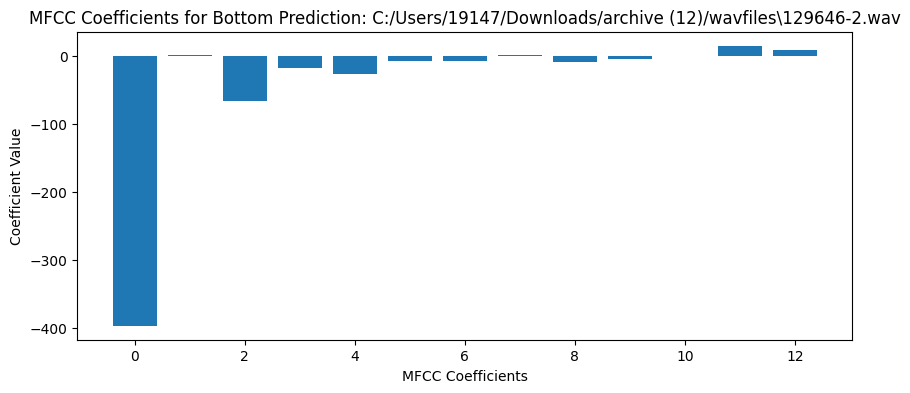

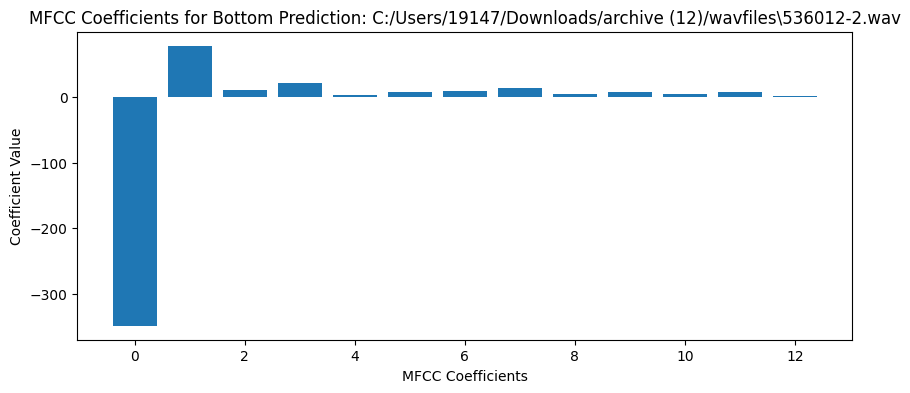

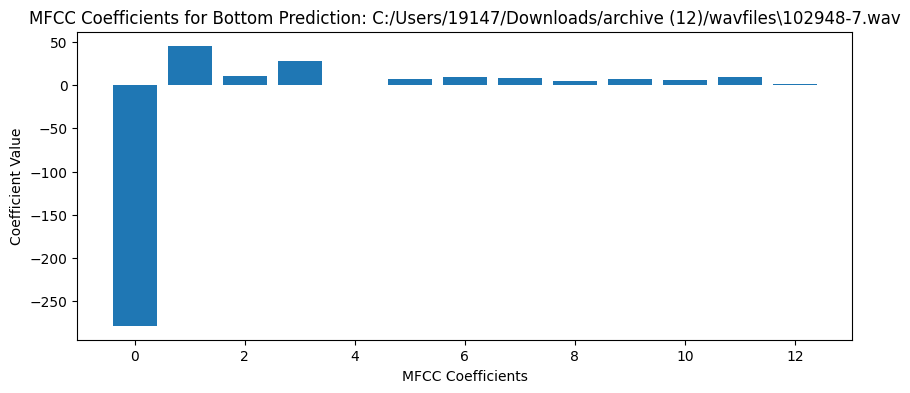

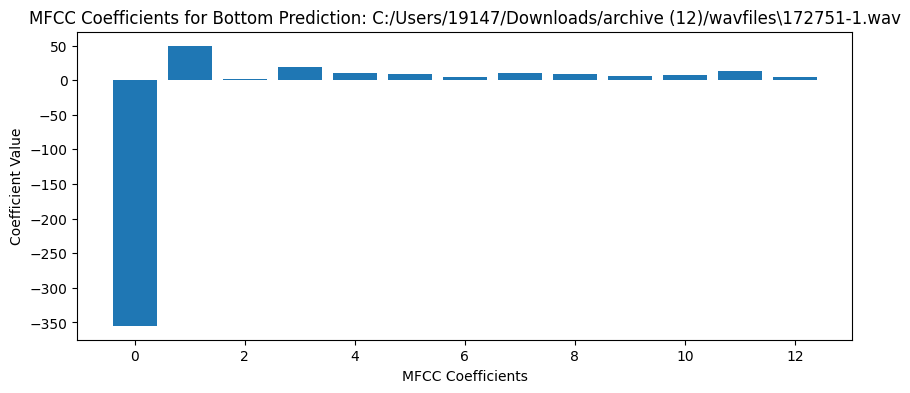

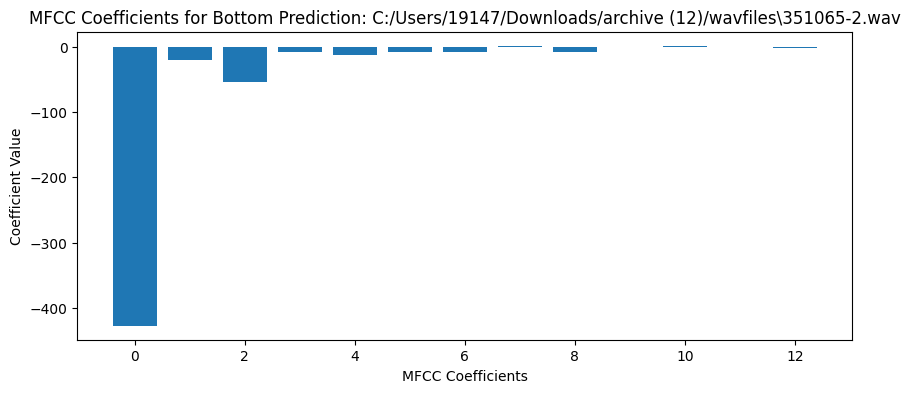

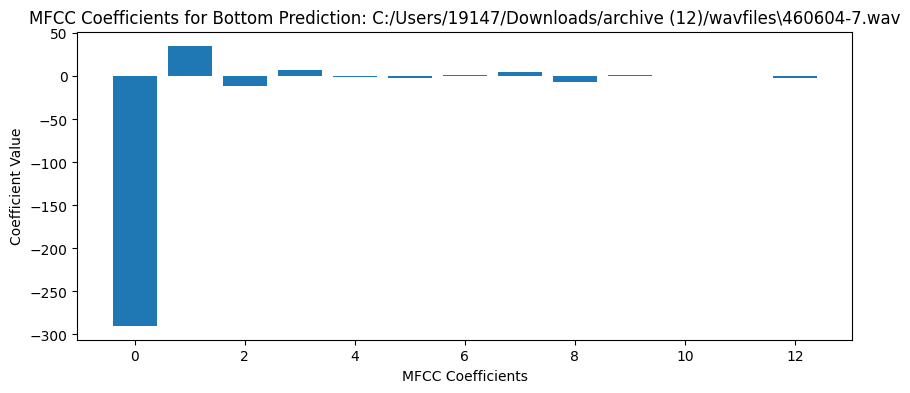

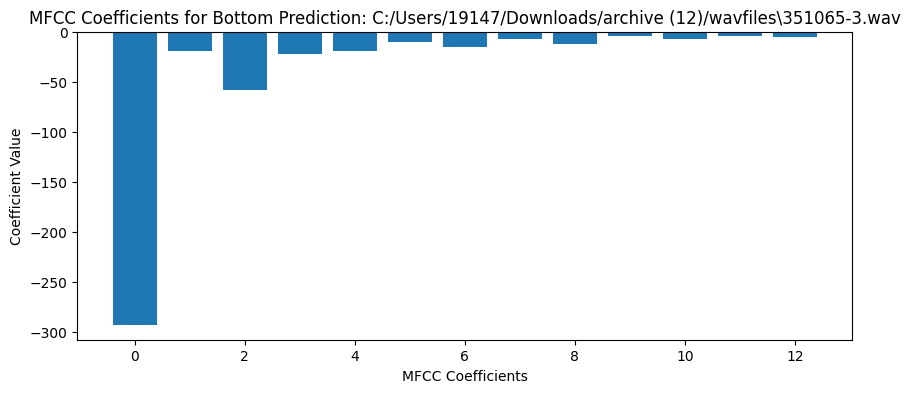

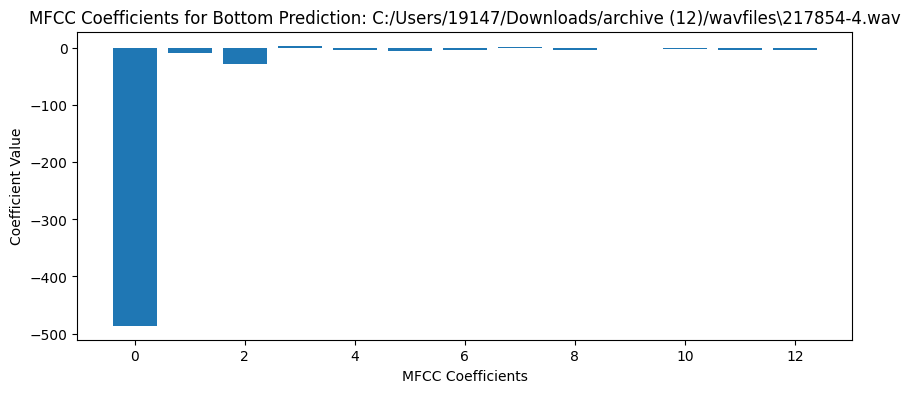

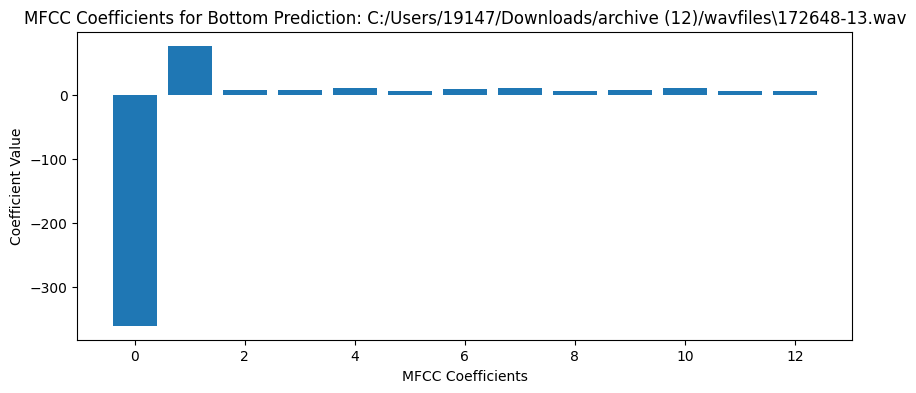

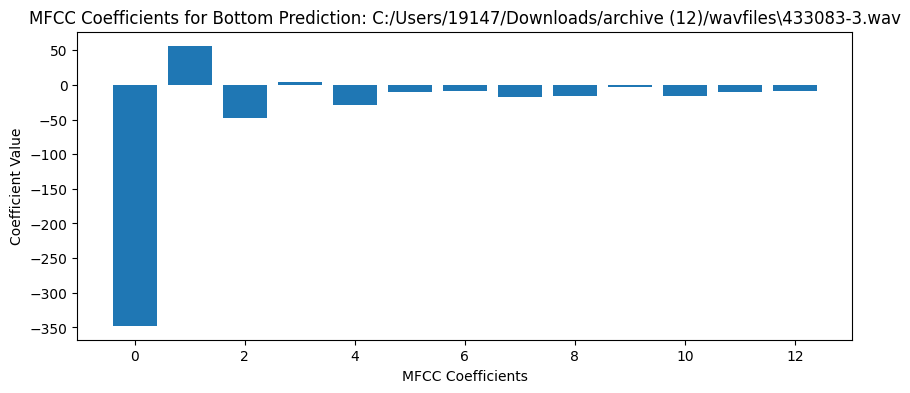

In [15]:
for index in bottom_10_indices_mfcc:
    least_confident_mfcc = X_test[index]
    least_confident_file_path = files_test[index]
    plot_title = f'MFCC Coefficients for Bottom Prediction: {least_confident_file_path}'
    plot_mfcc_coefficients(least_confident_mfcc, plot_title)


In [16]:
# indices where predictions do not match the actual labels
incorrect_indices_mfcc = np.where(y_pred != y_test)[0]
print(incorrect_indices_mfcc)

[   5   26   43   48   50   52   69   70   82   93   95  102  129  151
  173  180  188  205  221  228  231  235  238  249  255  270  271  277
  285  324  332  334  339  346  370  389  391  398  404  410  413  418
  427  442  453  454  477  495  500  509  511  515  529  532  537  558
  572  576  579  586  587  621  622  634  636  639  645  648  650  680
  686  705  721  722  729  733  747  766  778  779  795  796  805  807
  814  833  862  865  888  890  927  931  932  940  944  946  948  969
  987 1018 1045 1047 1049 1060 1065 1068 1079]


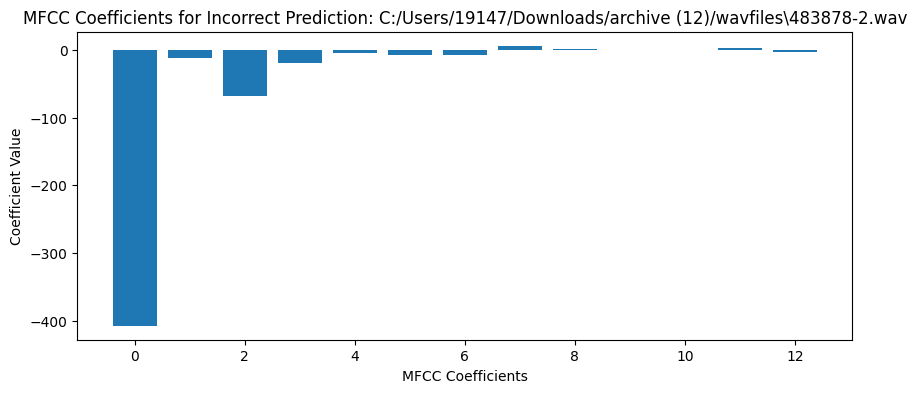

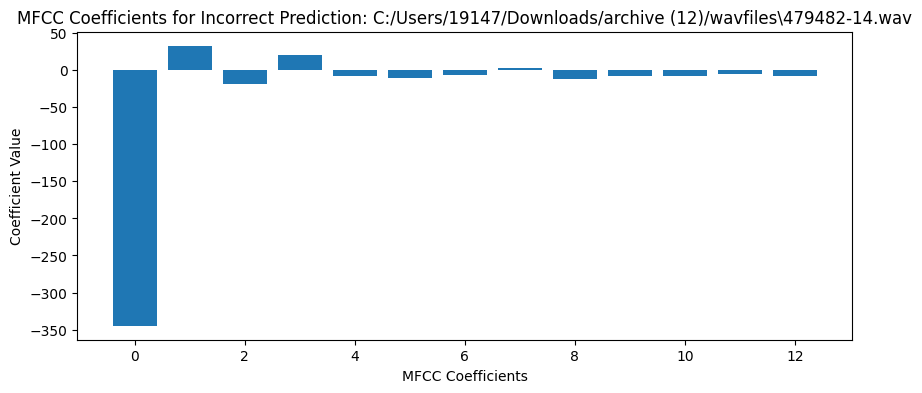

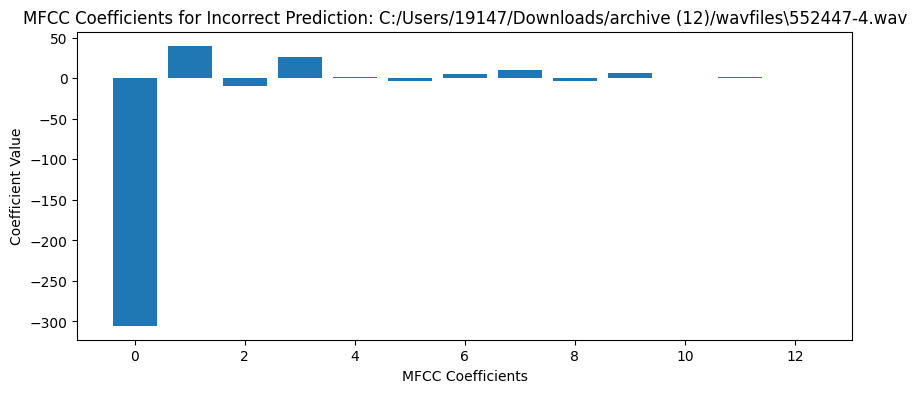

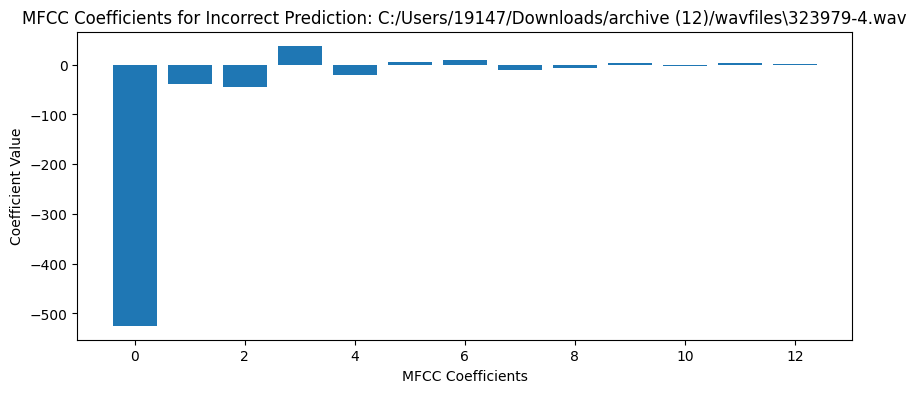

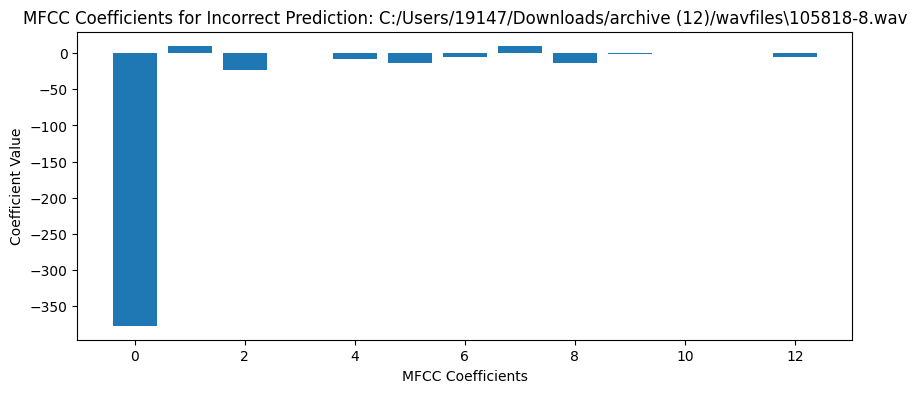

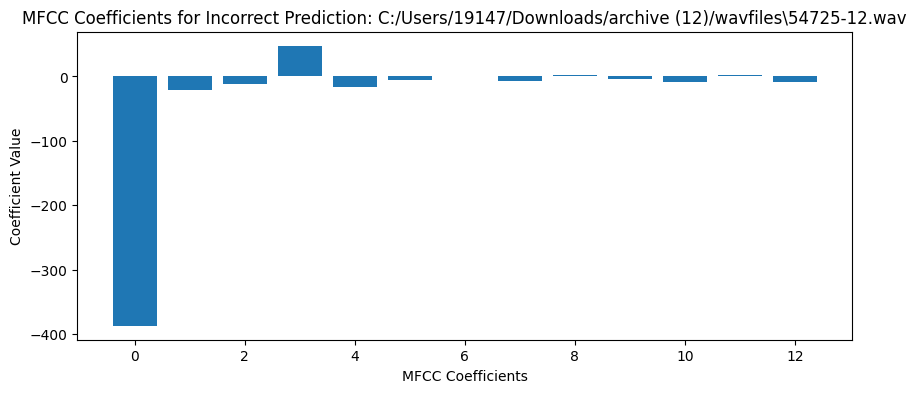

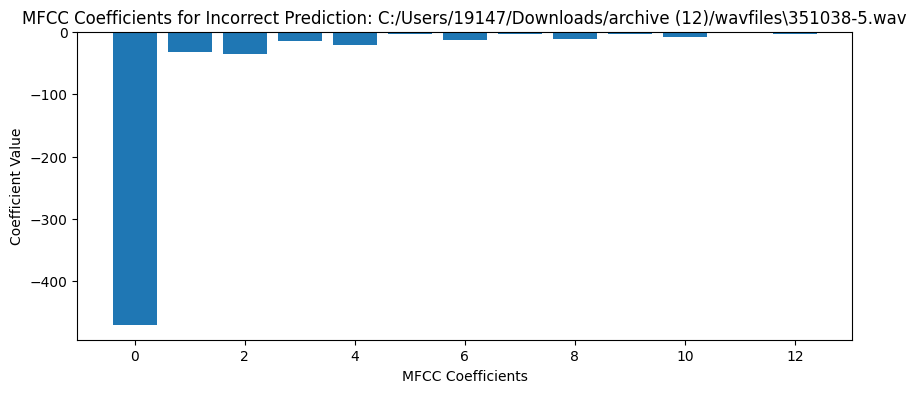

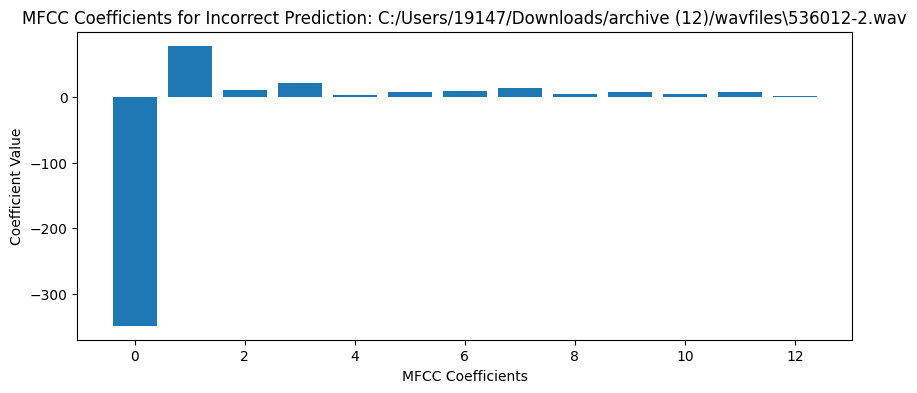

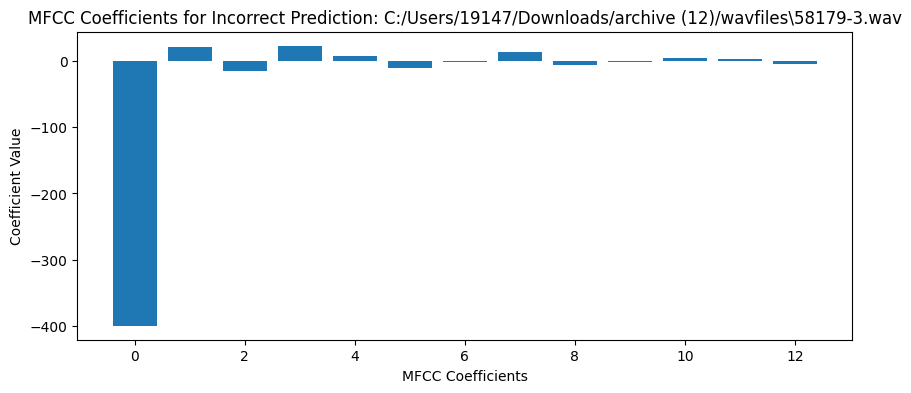

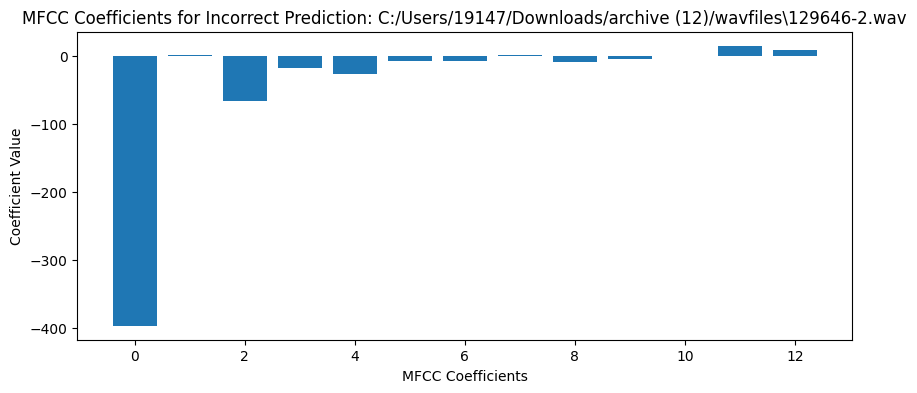

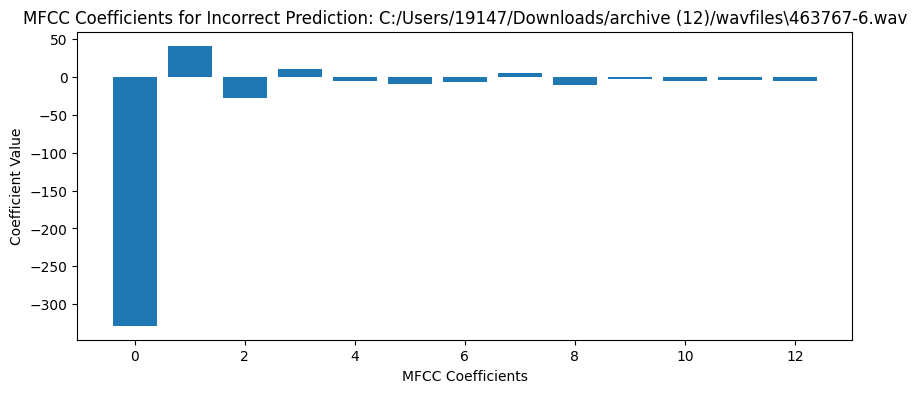

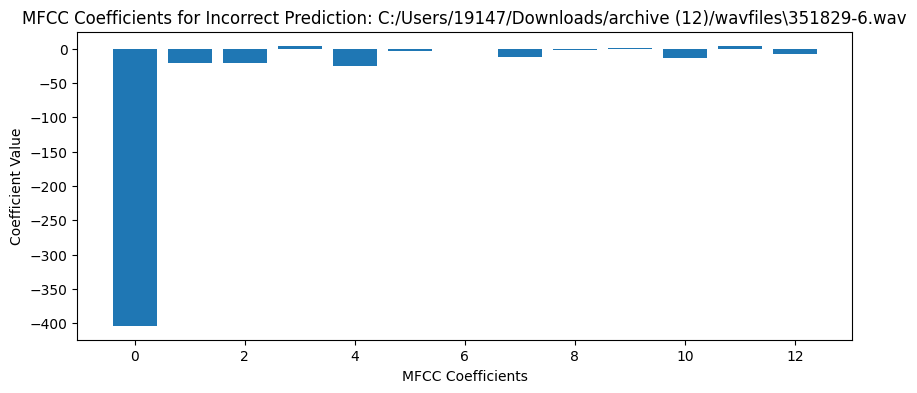

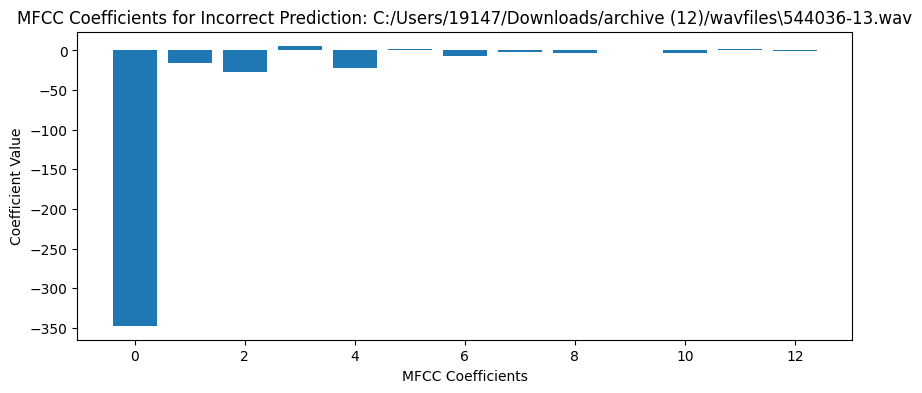

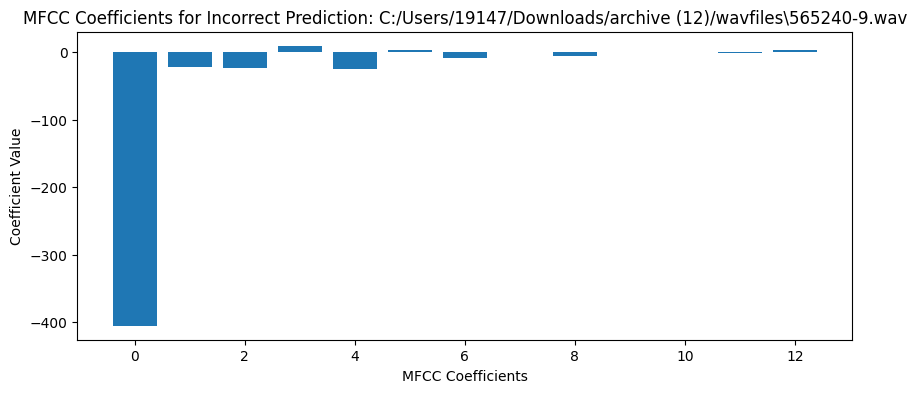

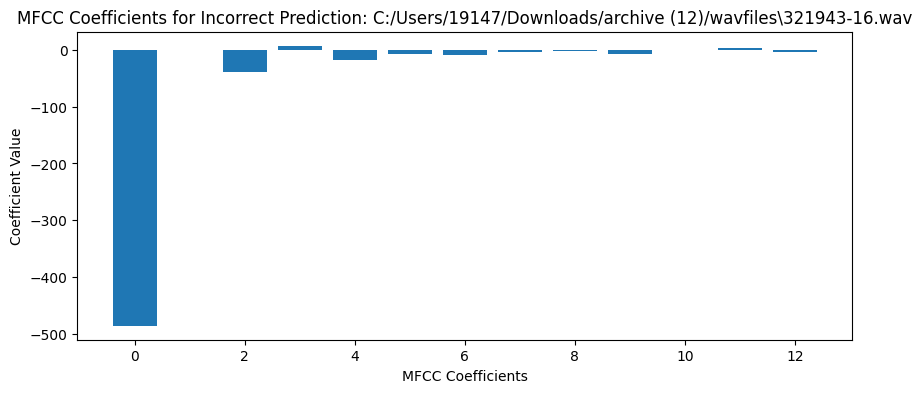

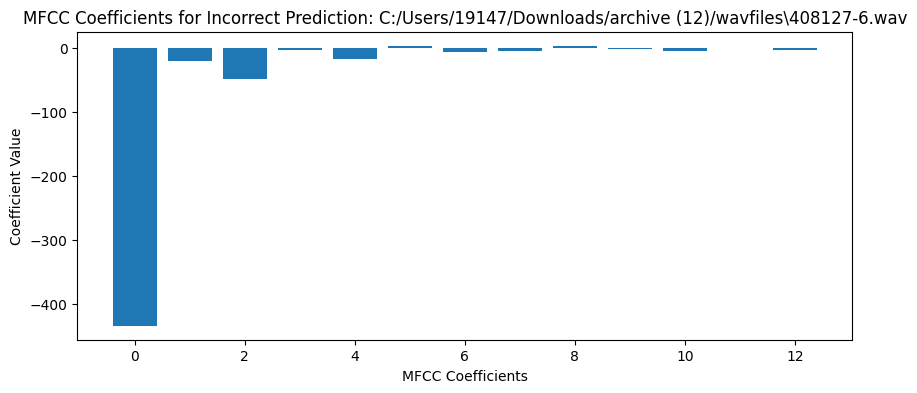

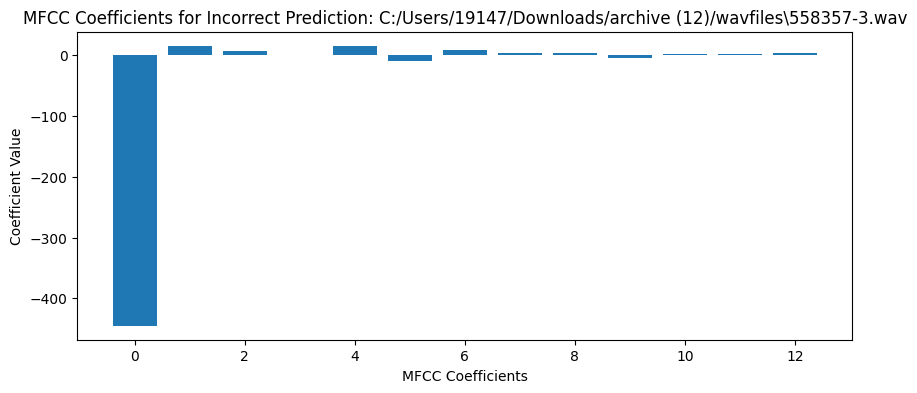

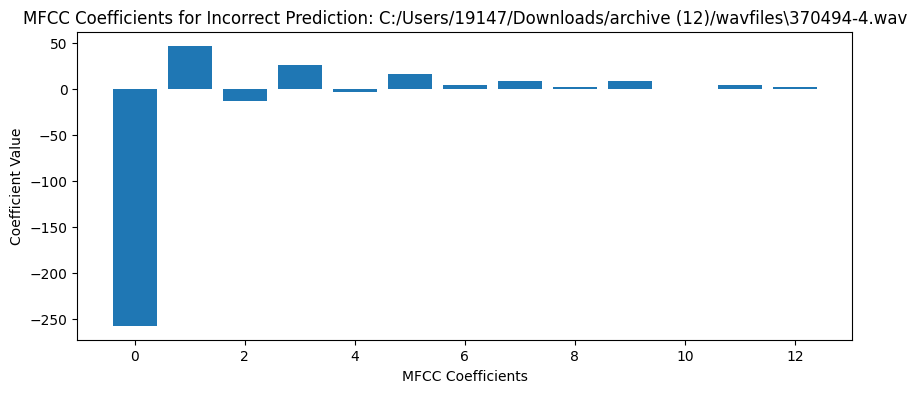

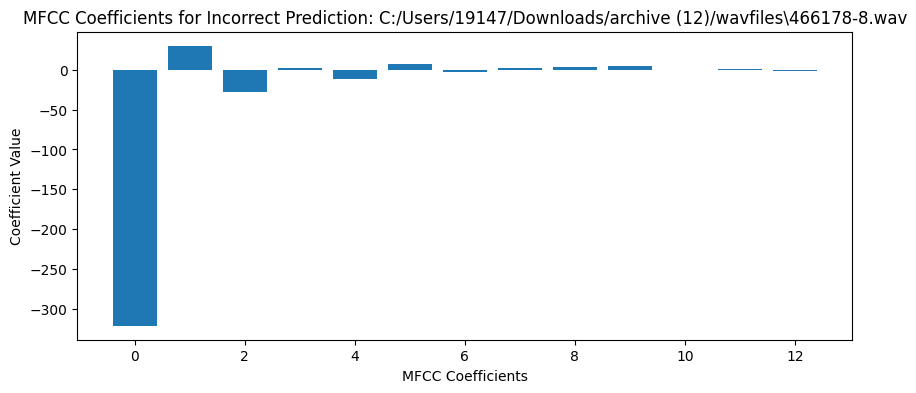

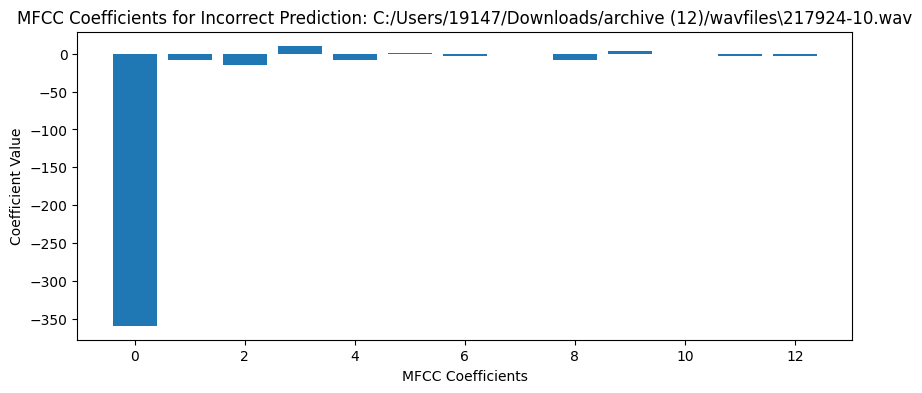

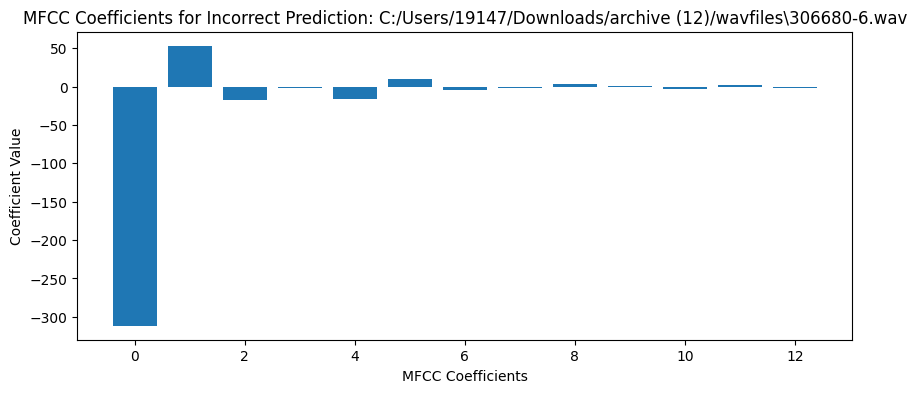

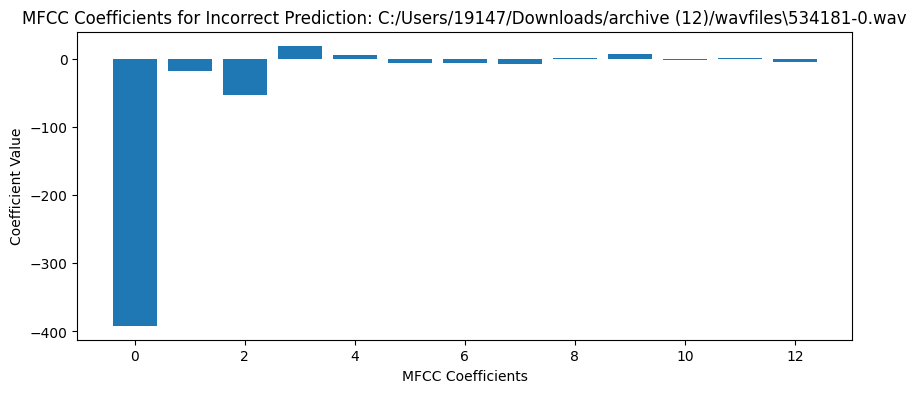

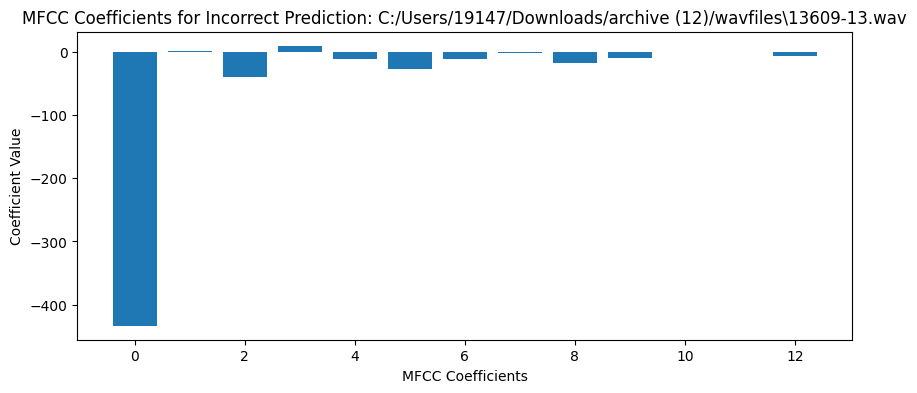

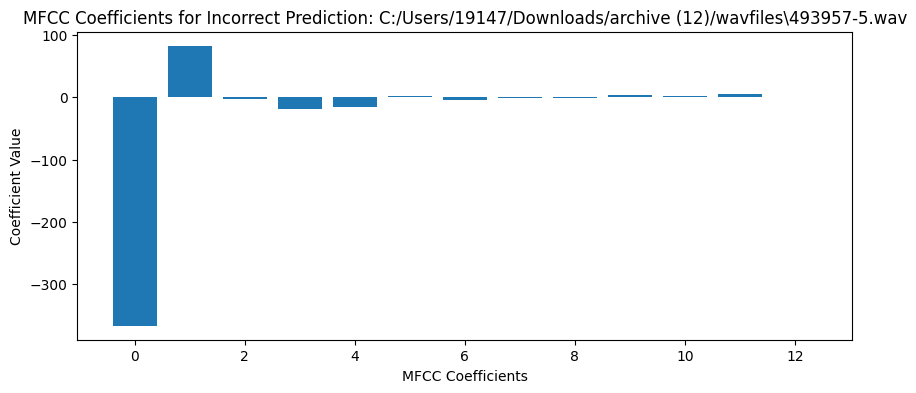

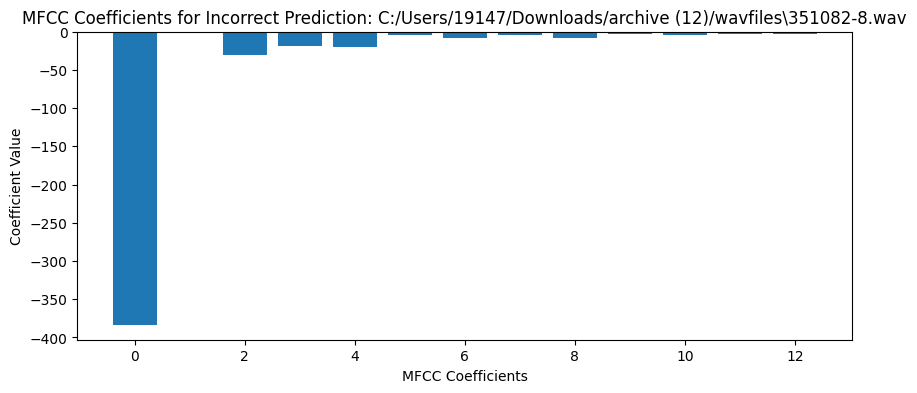

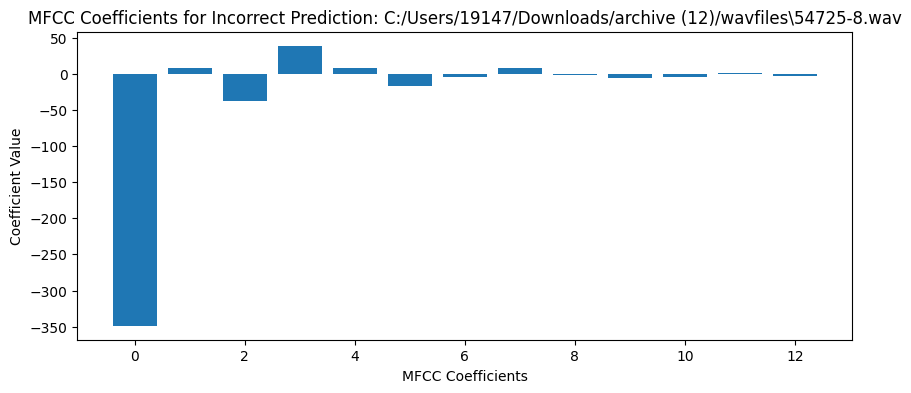

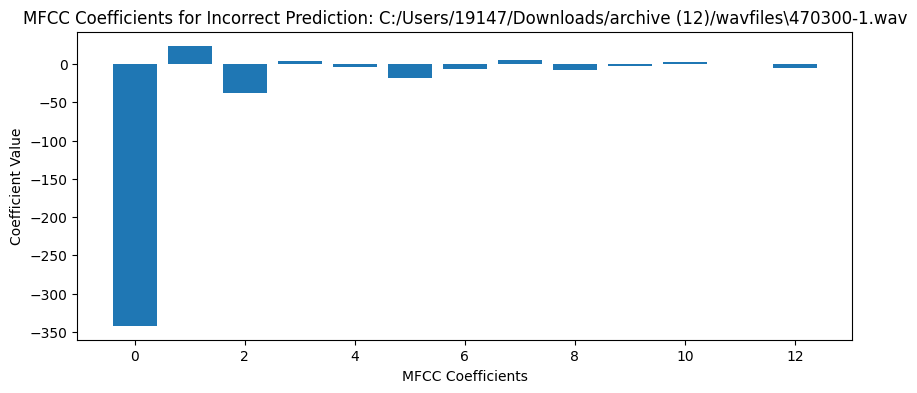

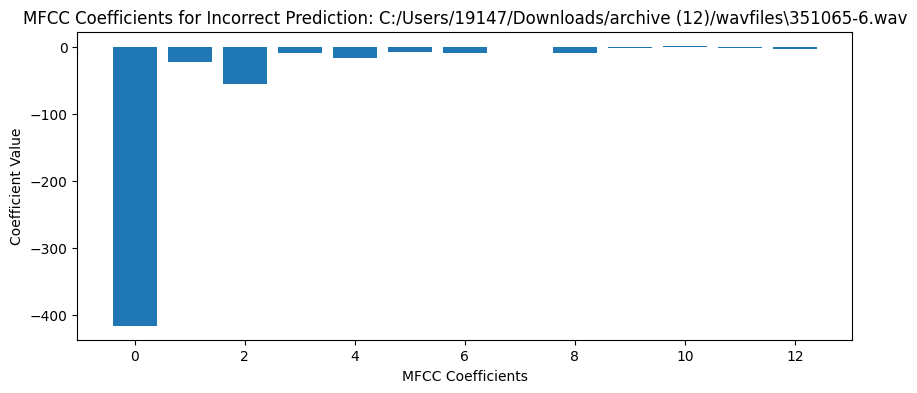

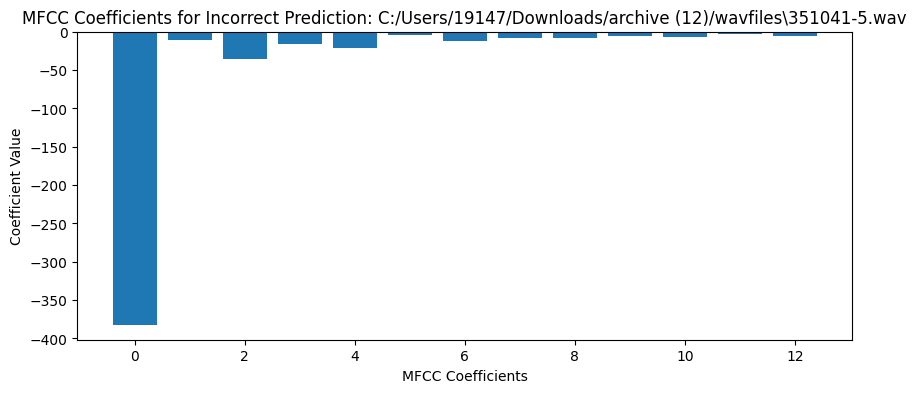

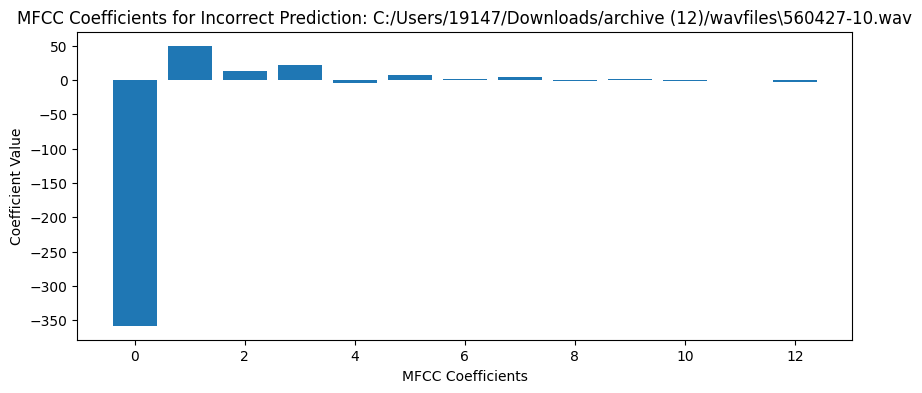

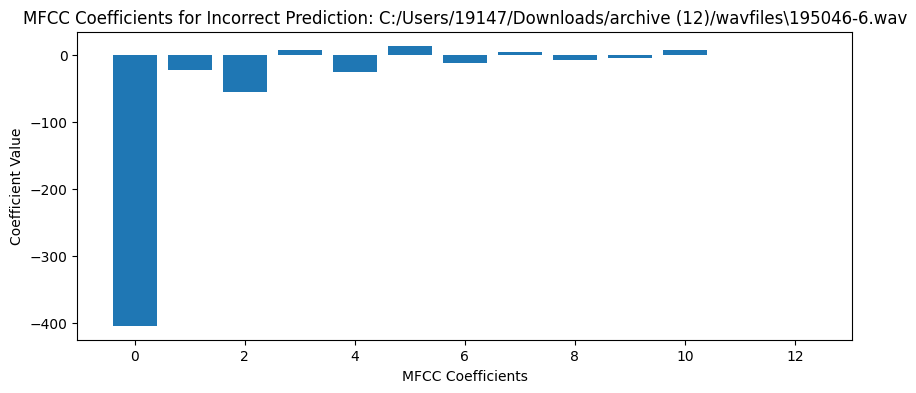

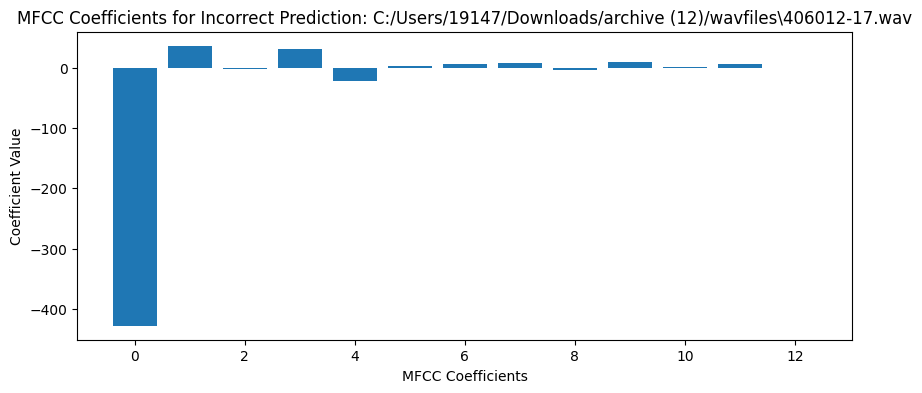

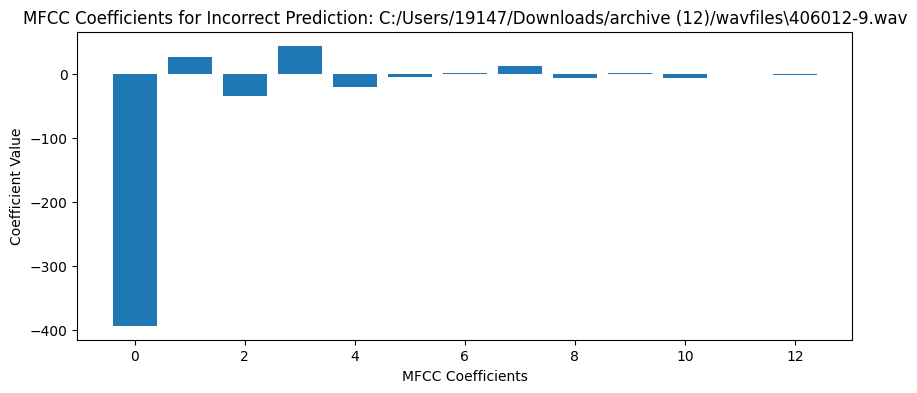

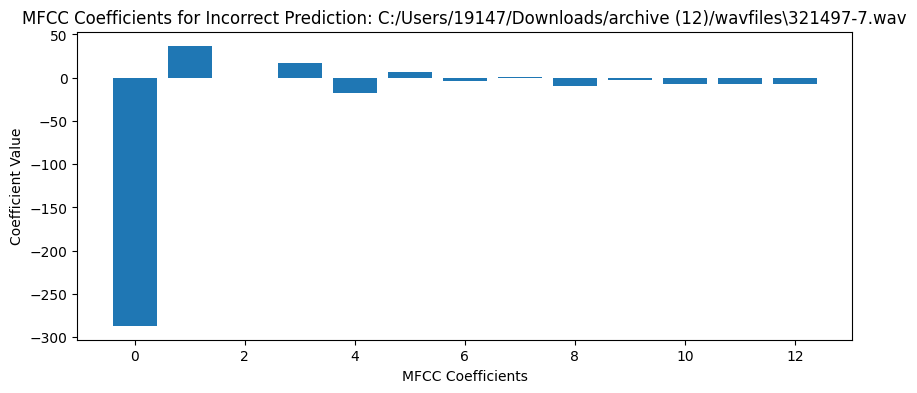

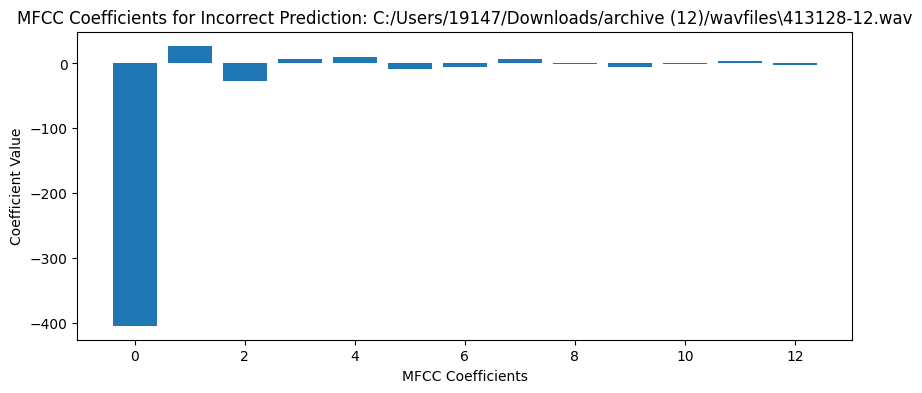

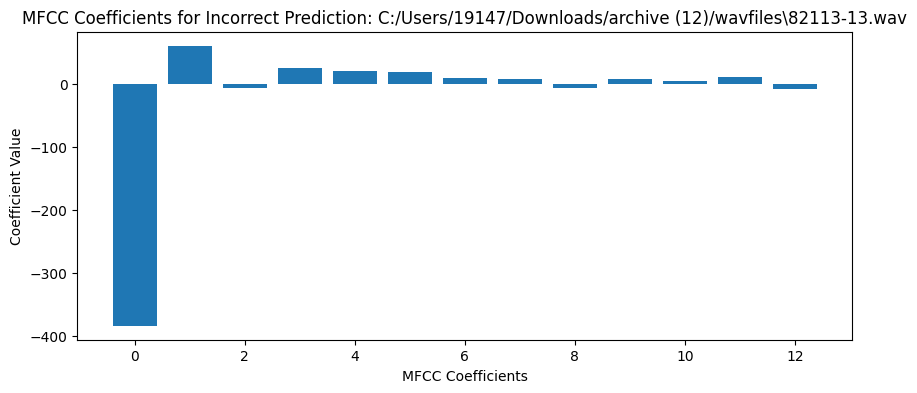

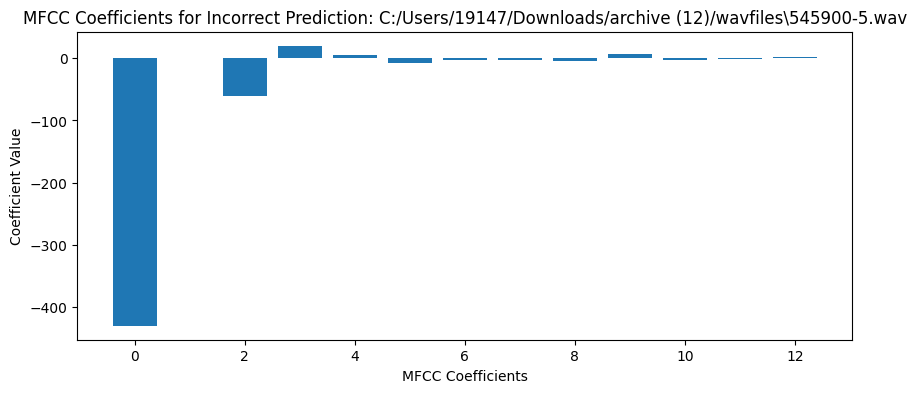

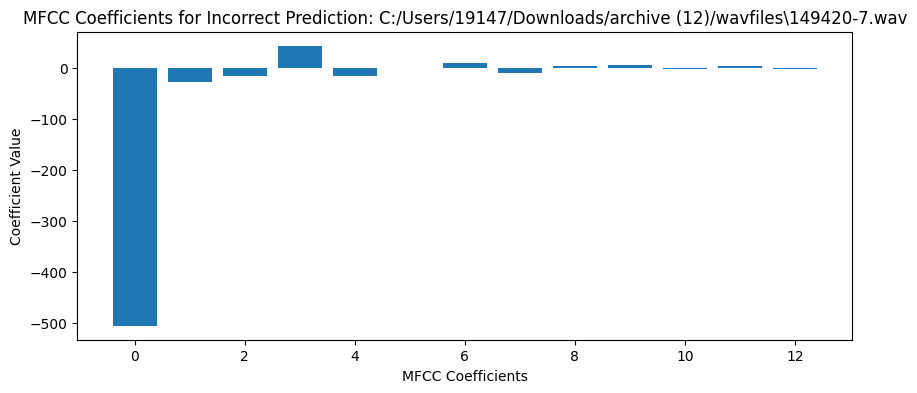

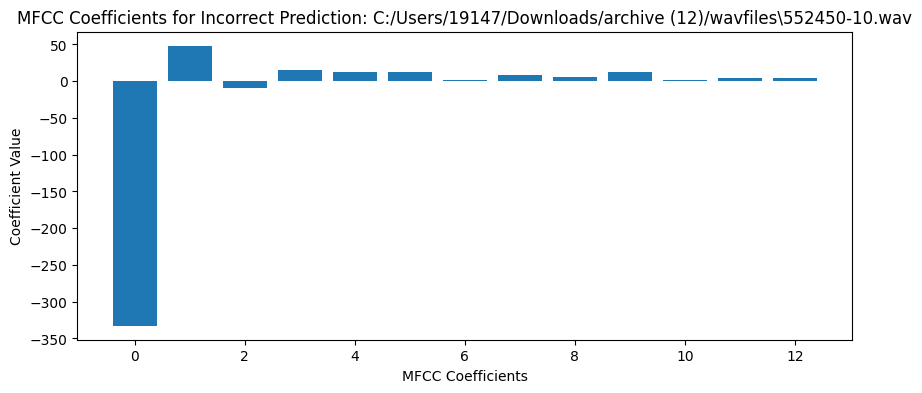

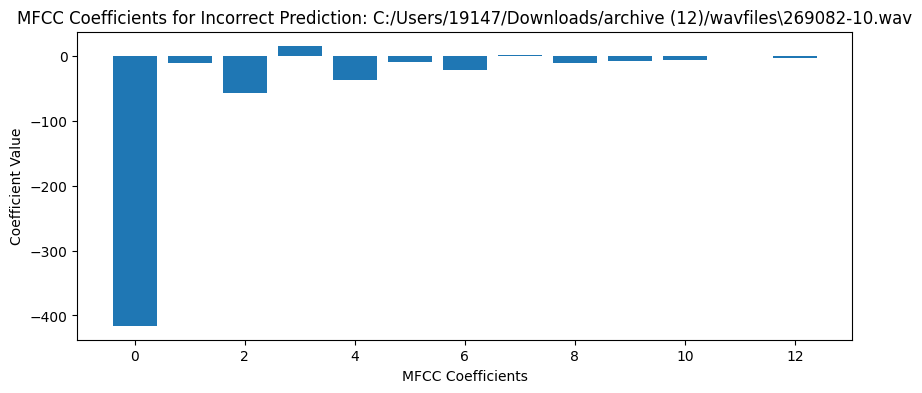

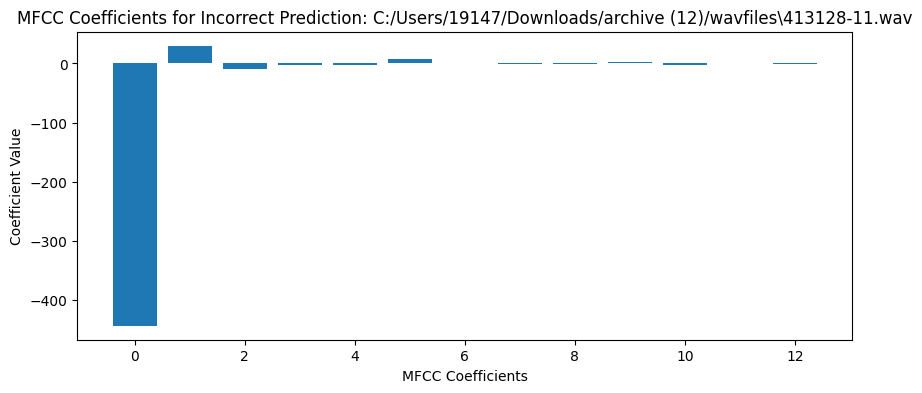

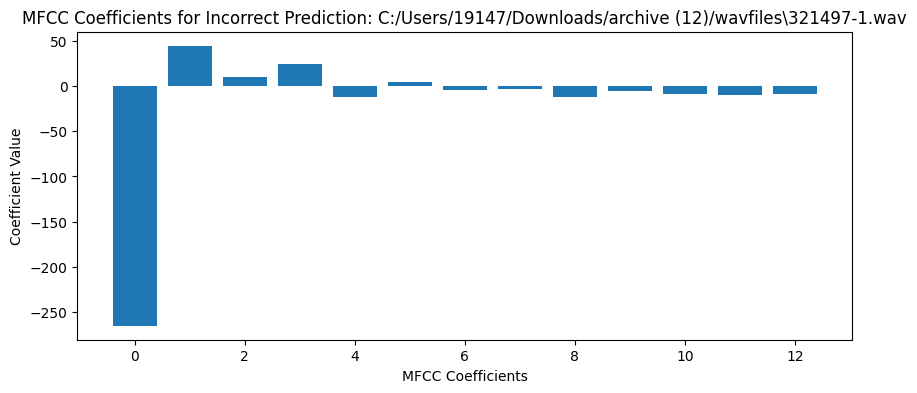

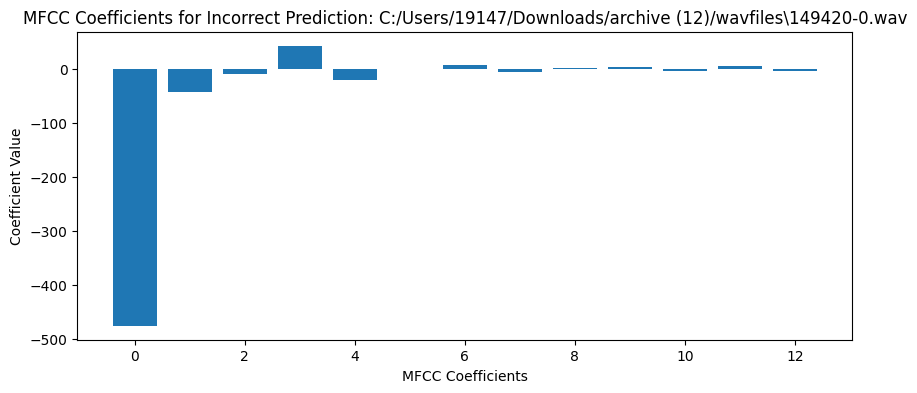

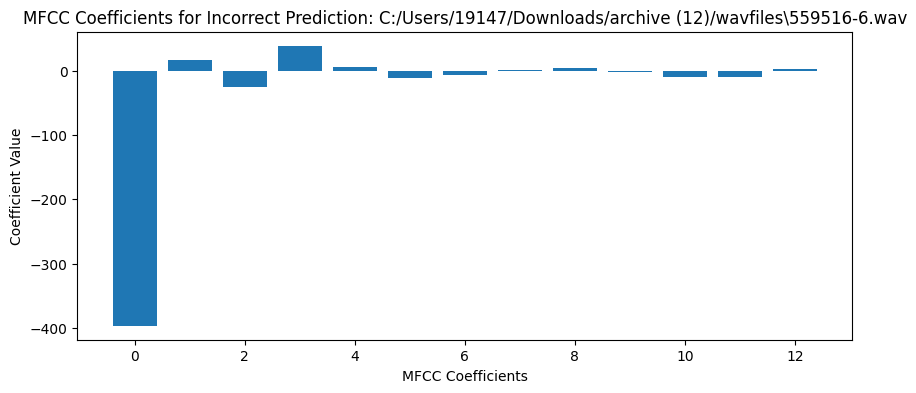

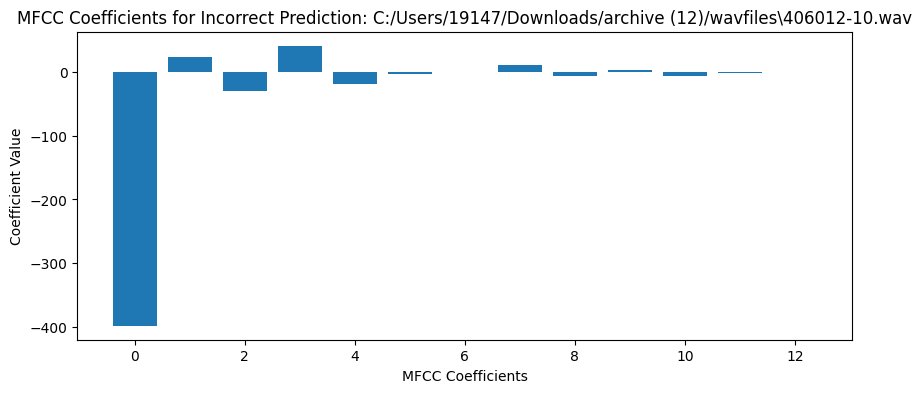

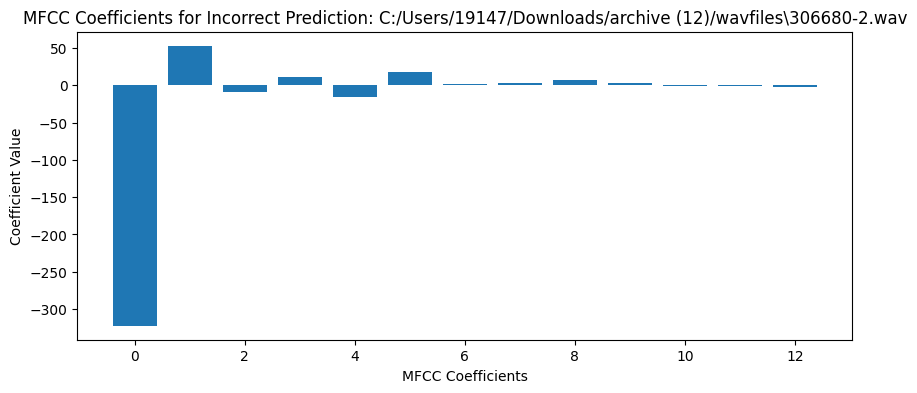

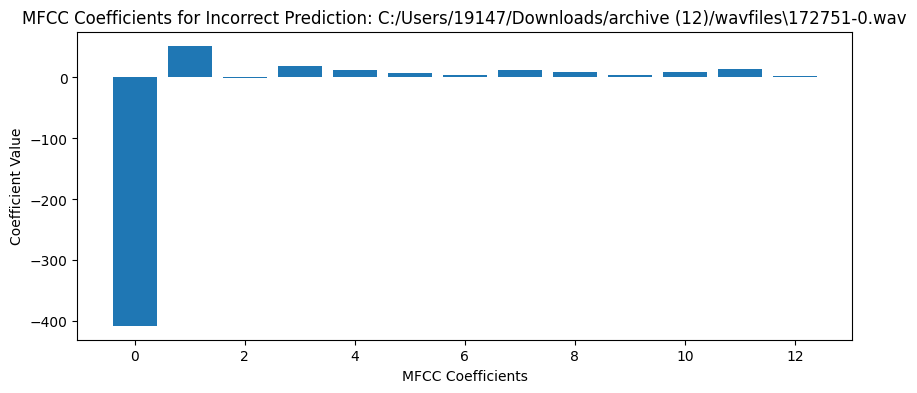

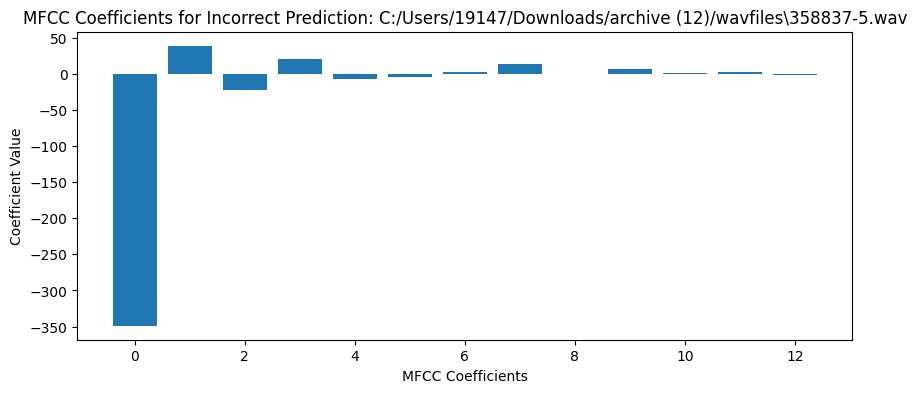

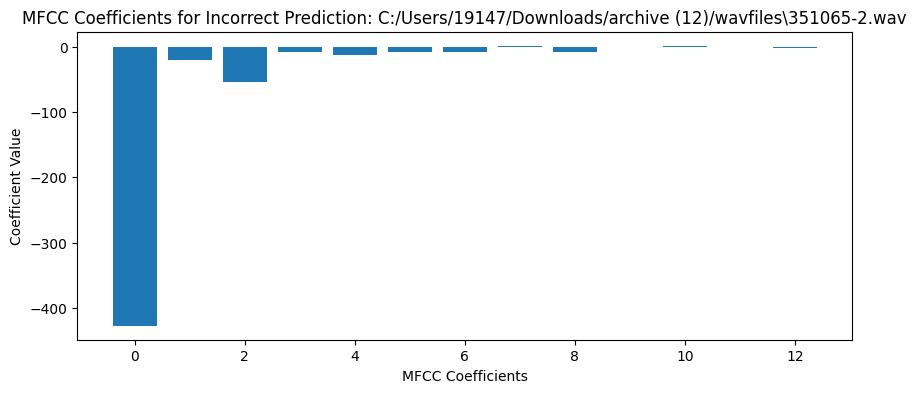

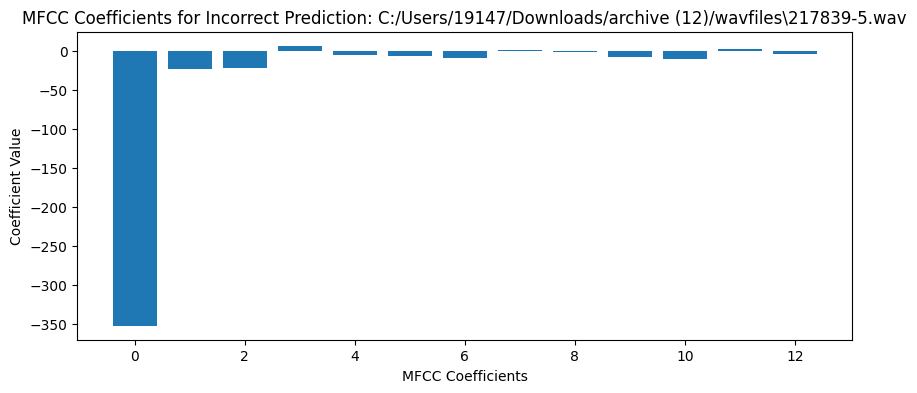

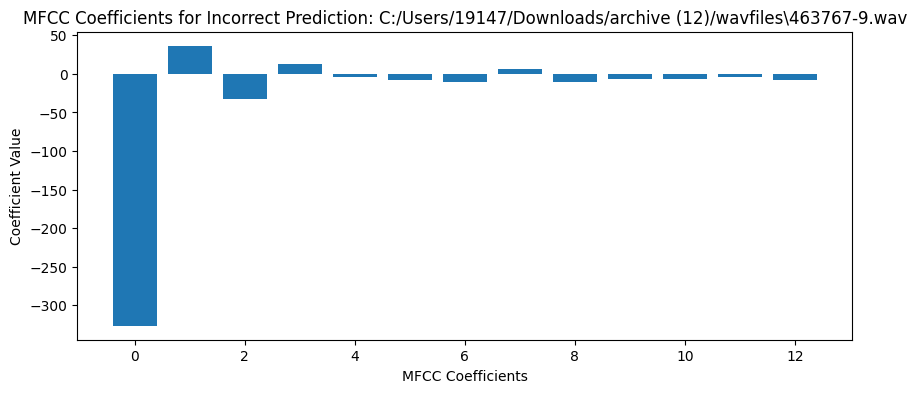

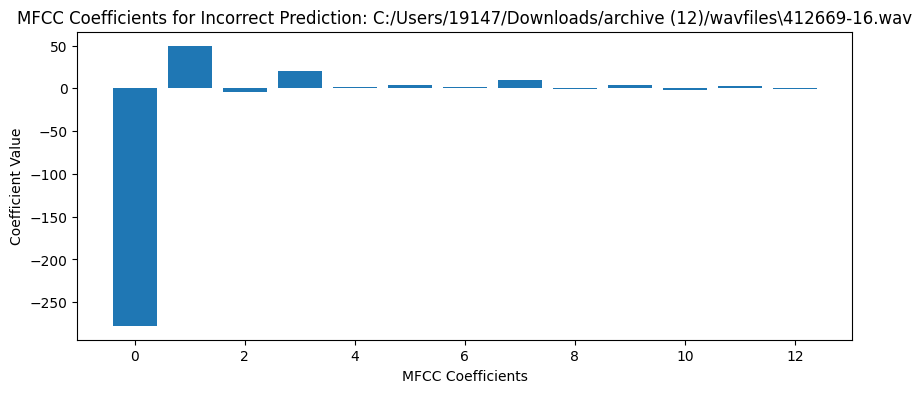

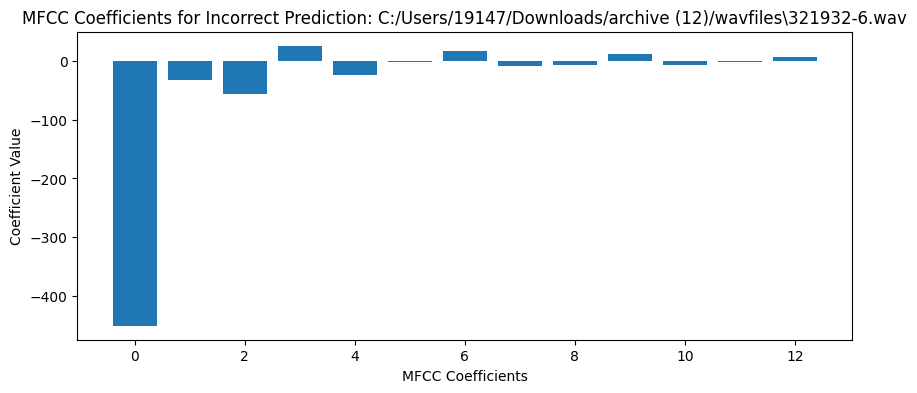

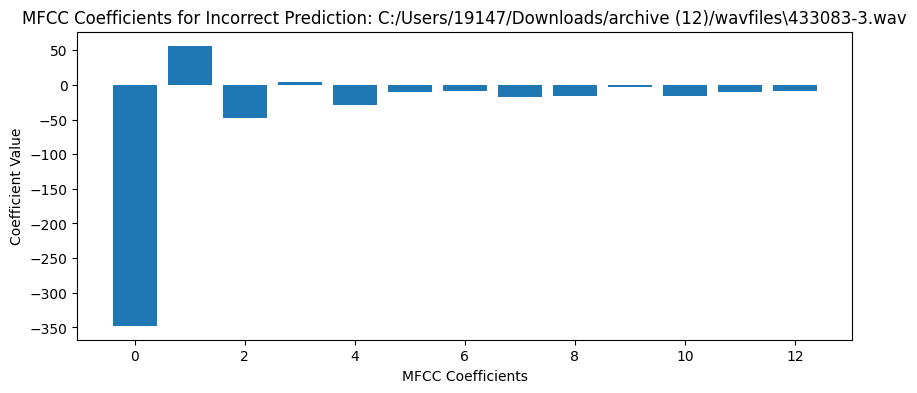

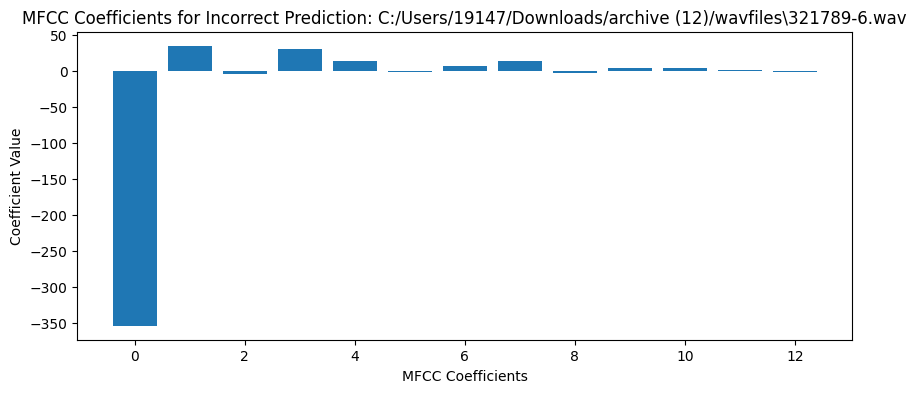

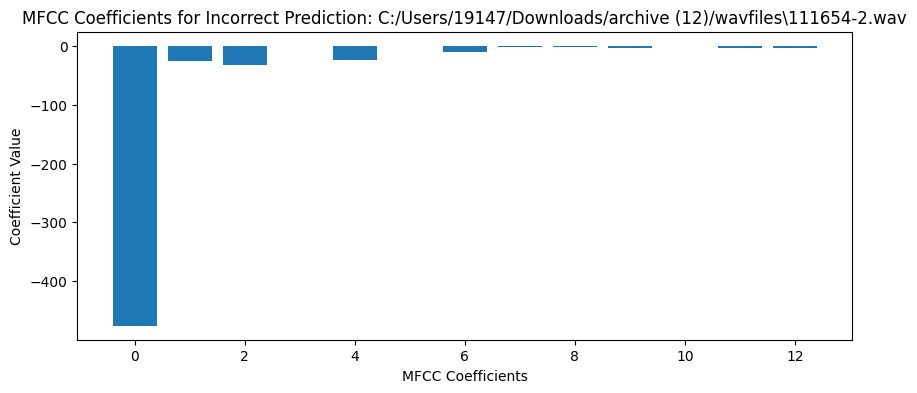

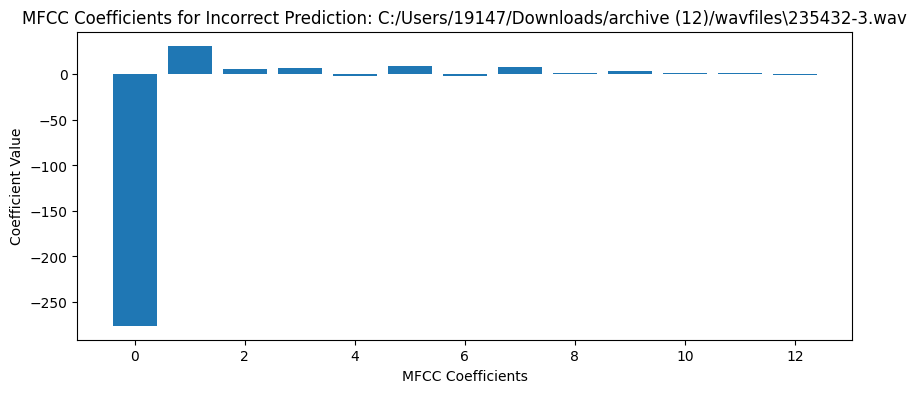

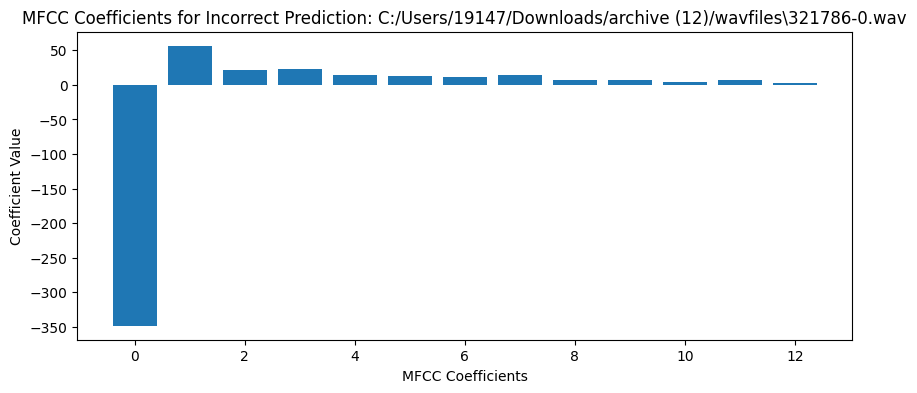

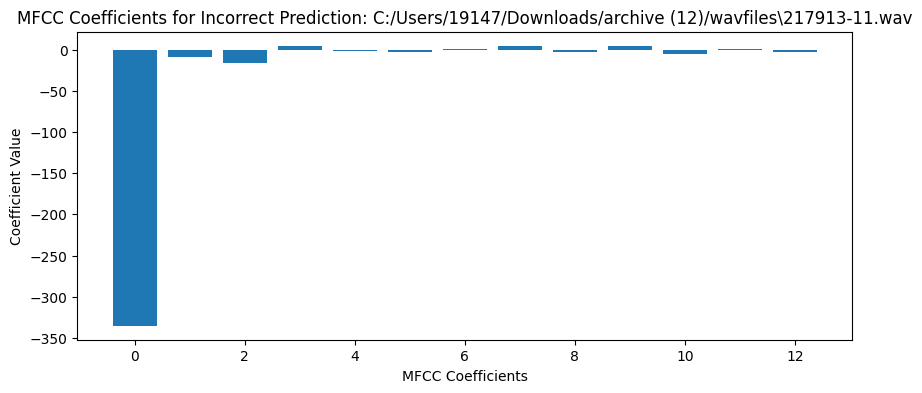

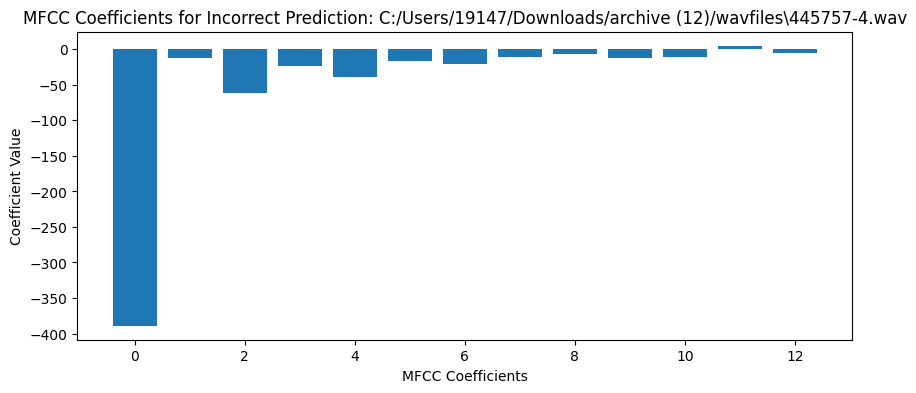

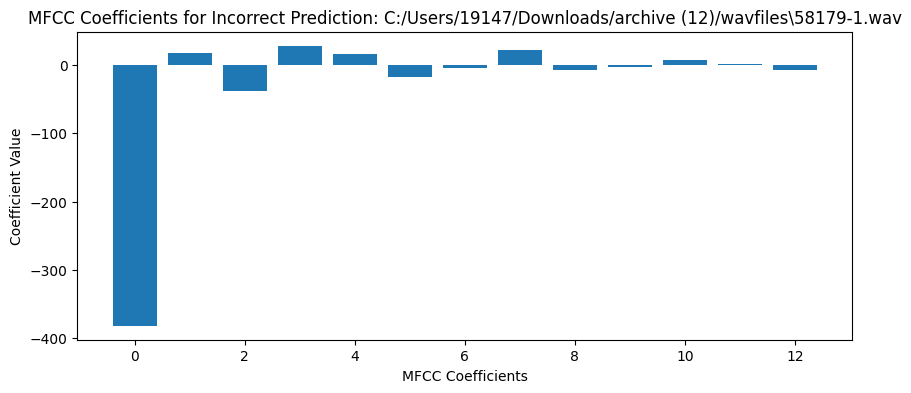

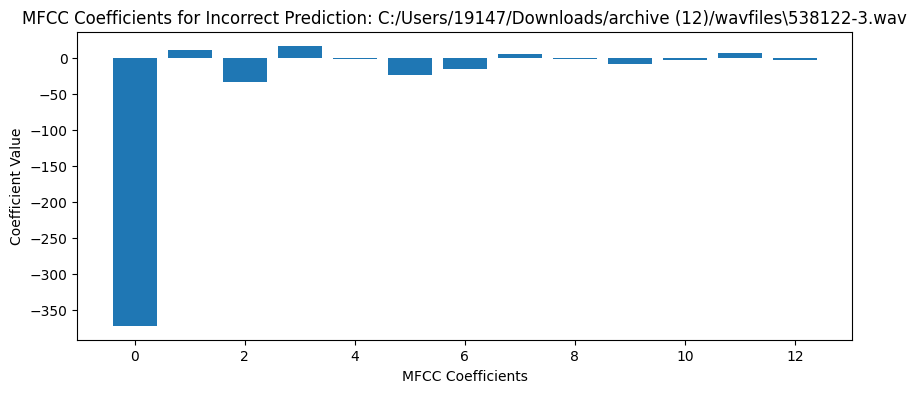

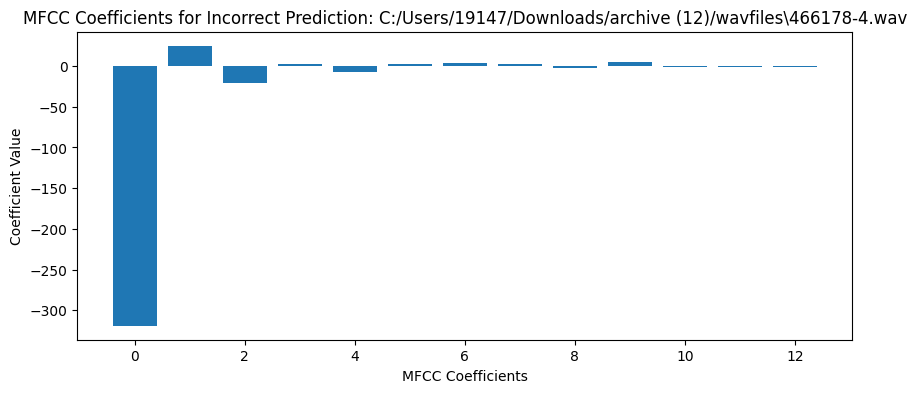

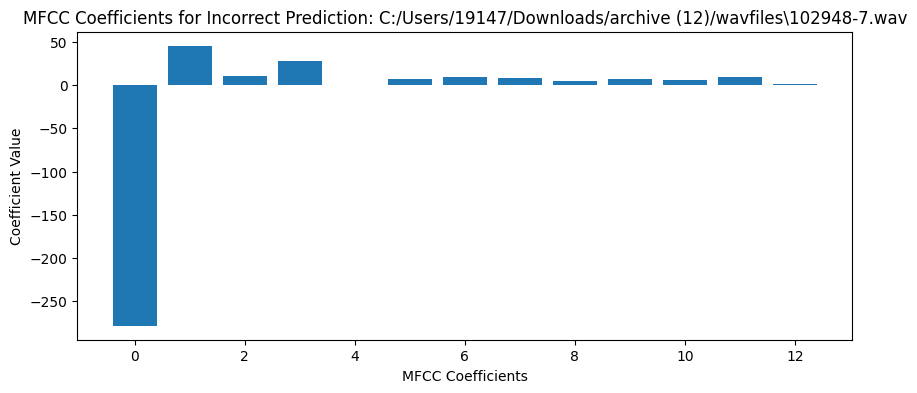

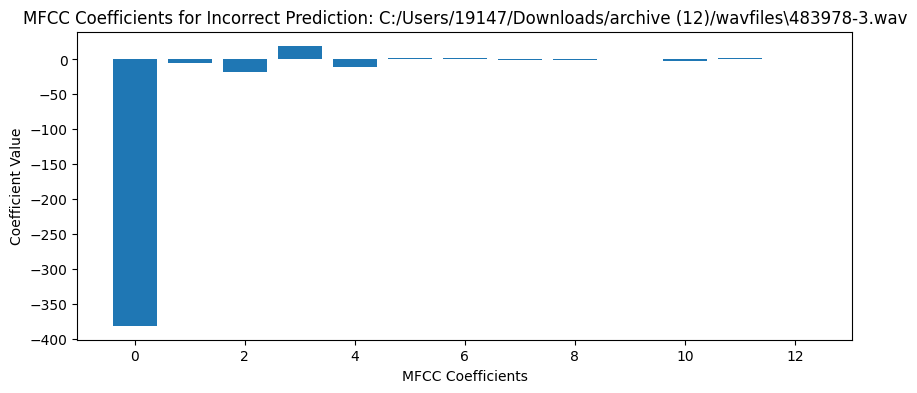

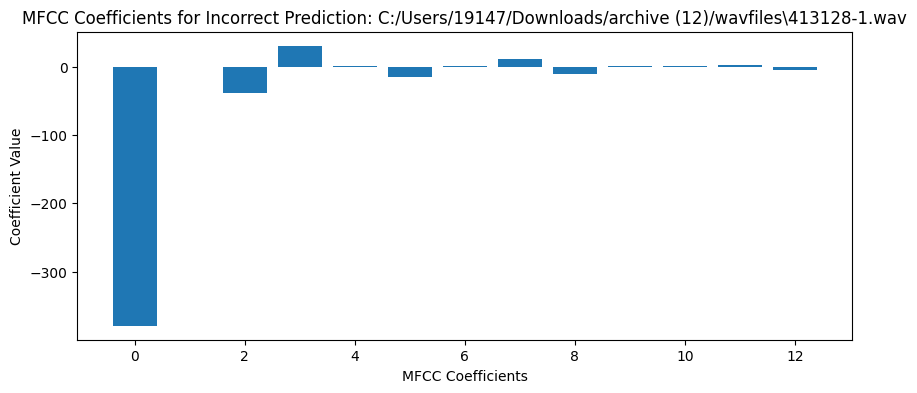

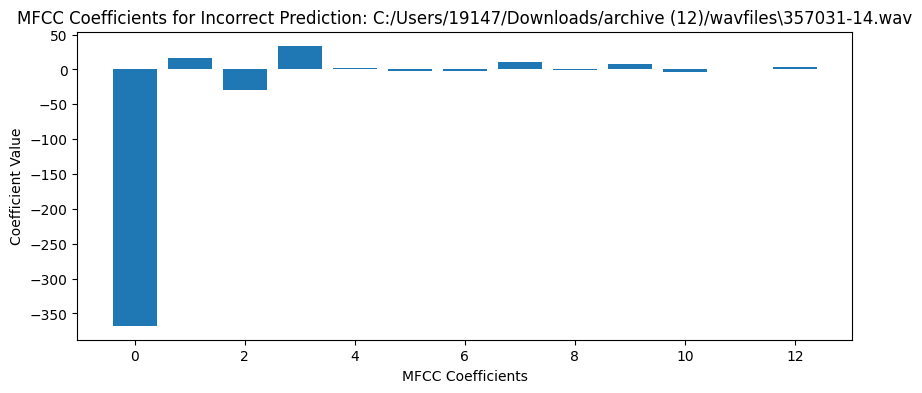

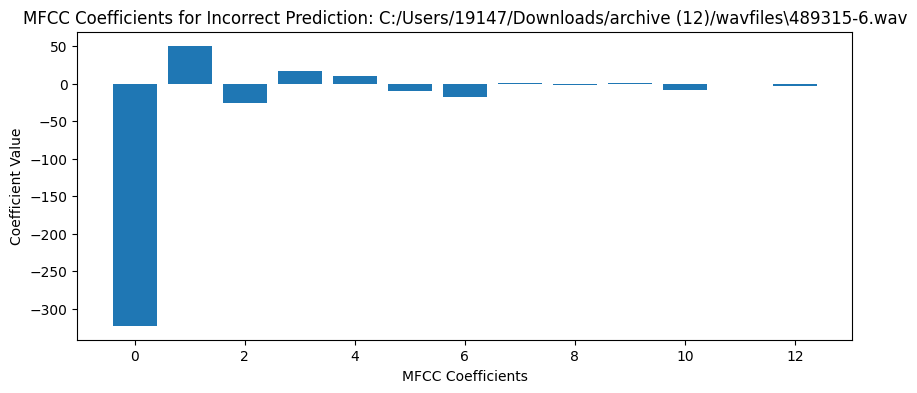

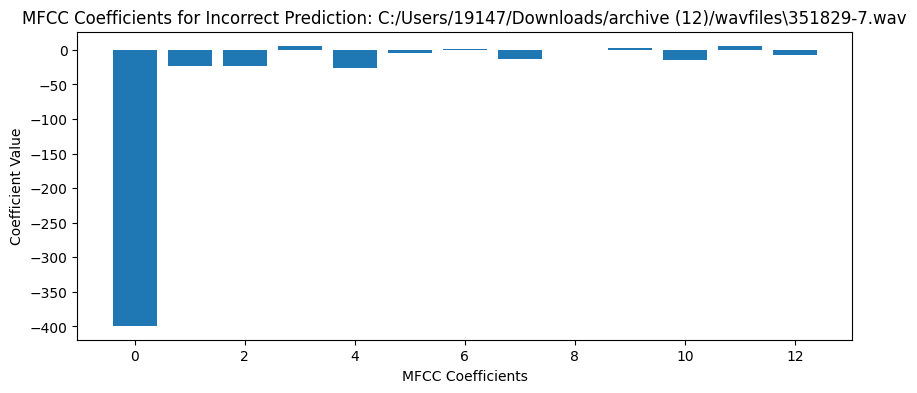

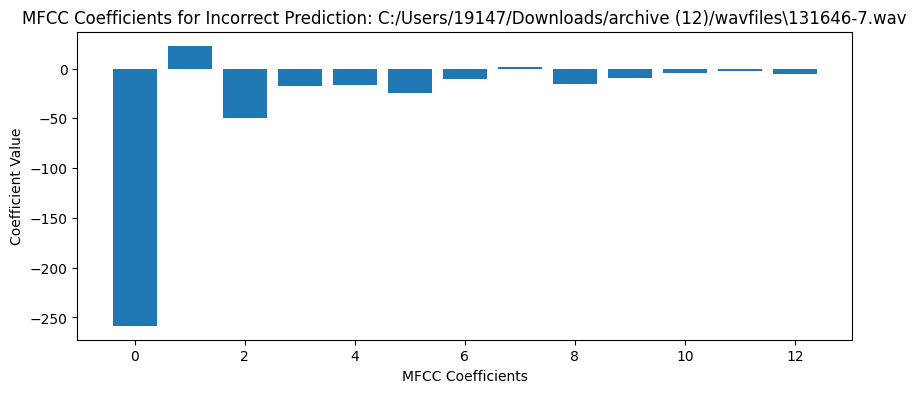

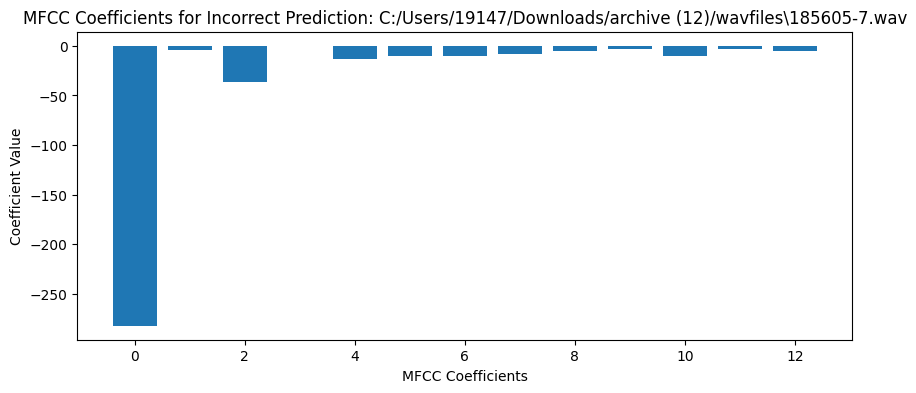

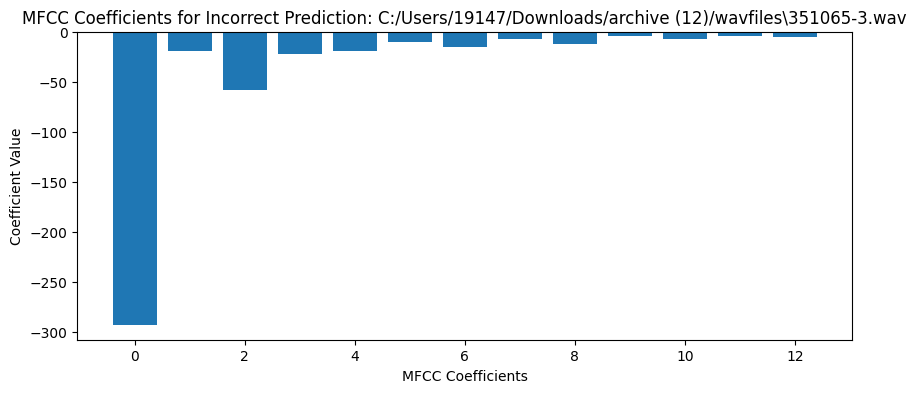

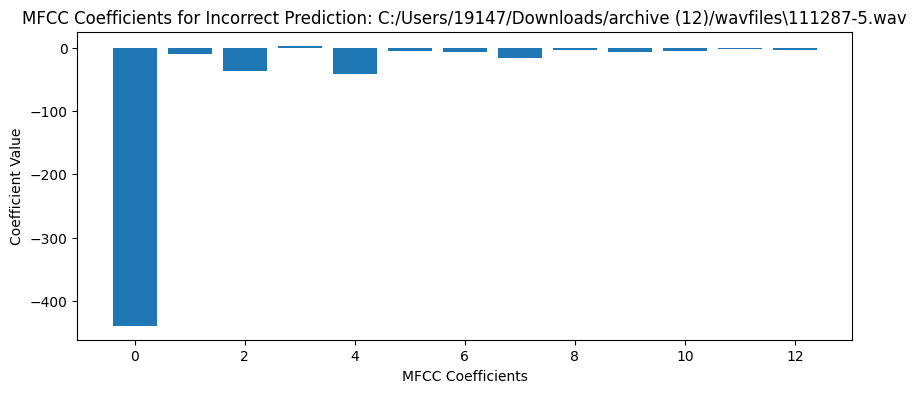

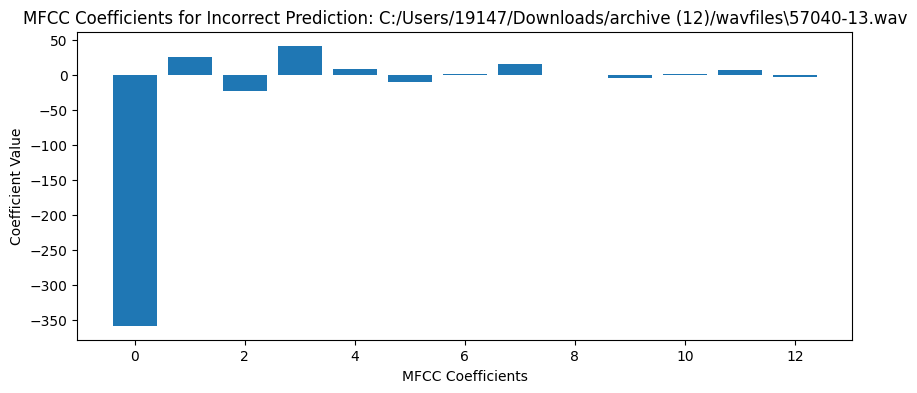

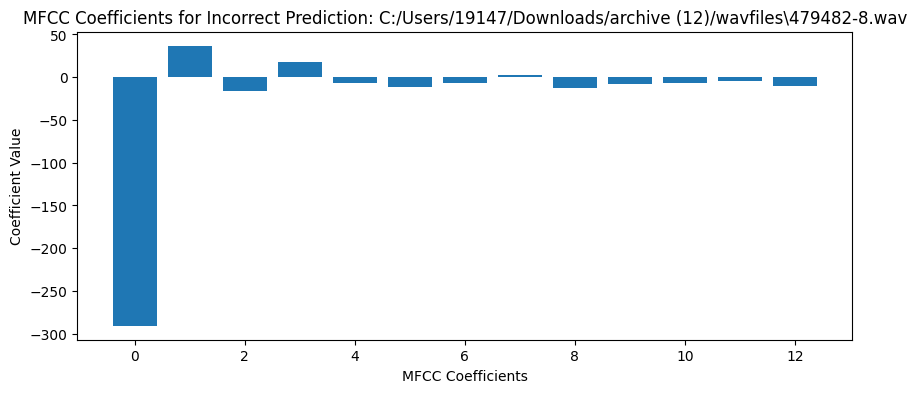

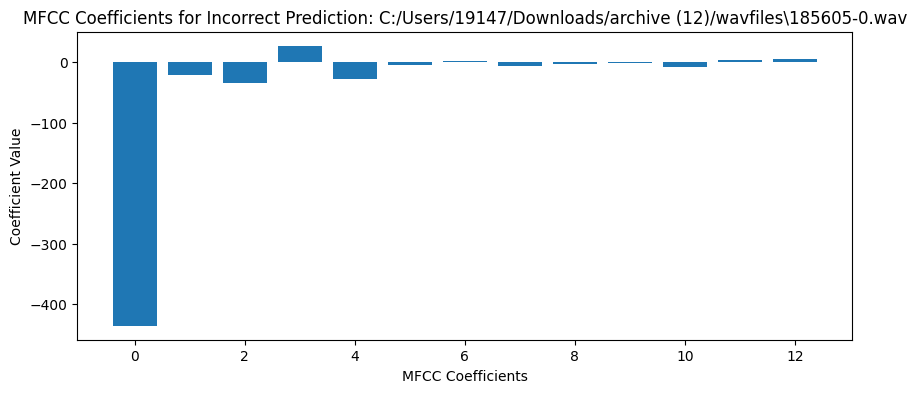

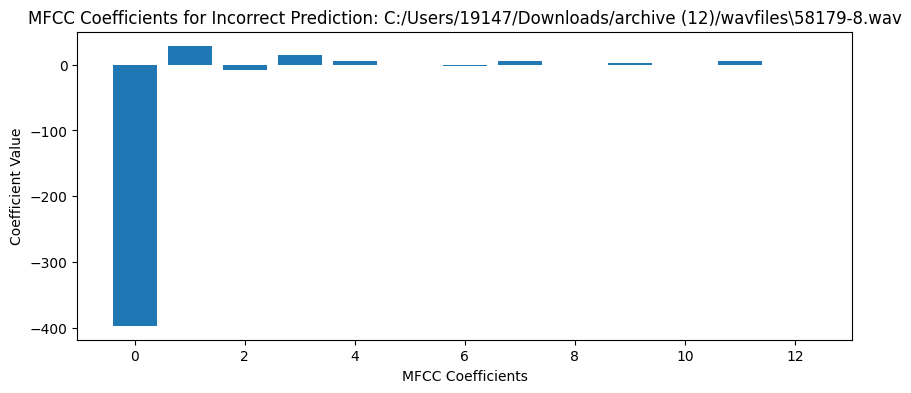

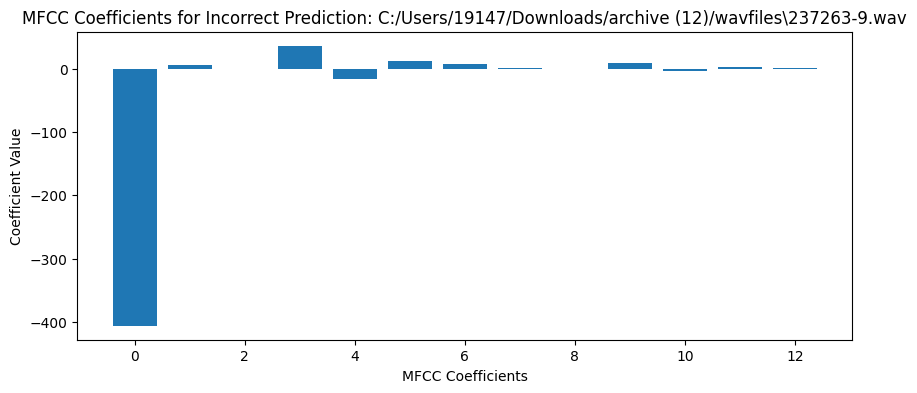

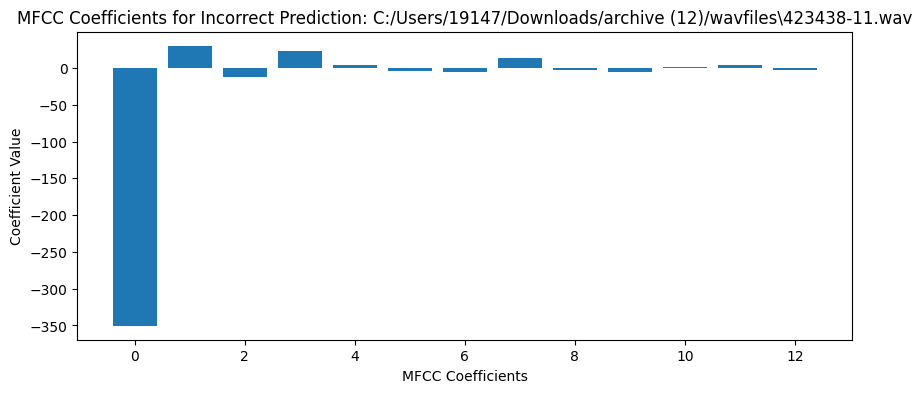

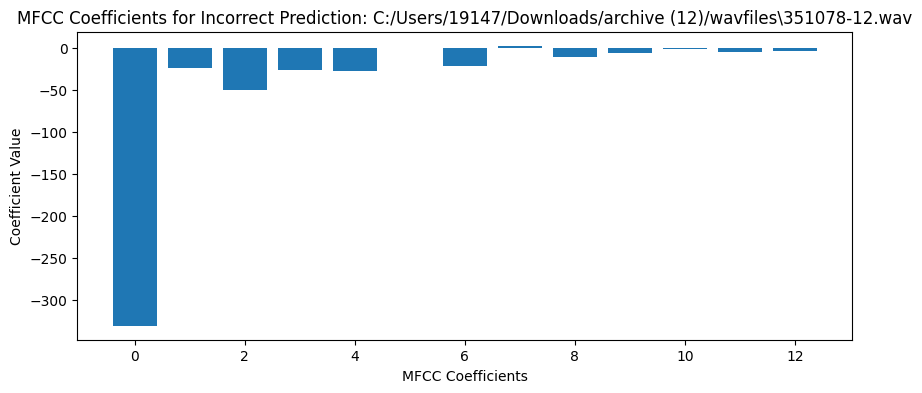

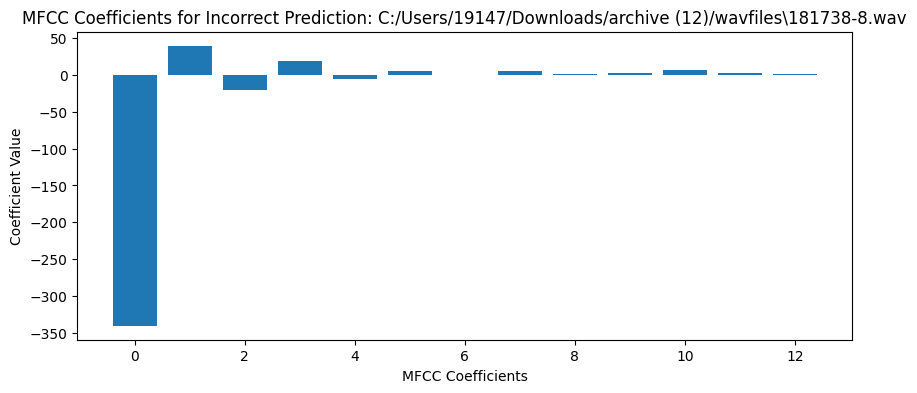

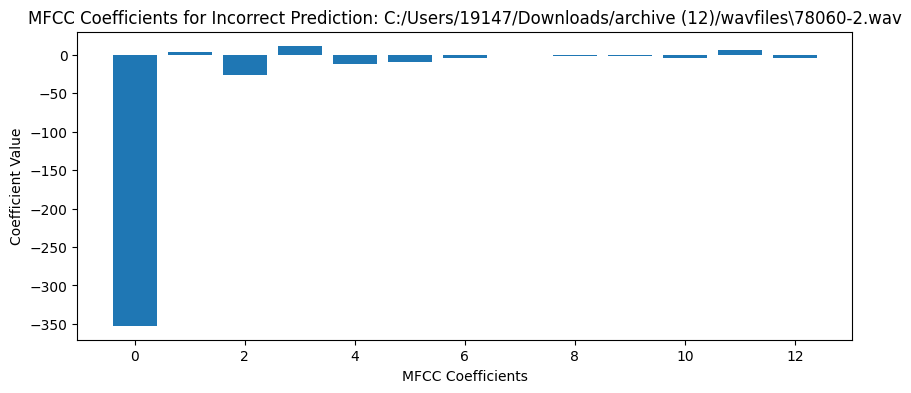

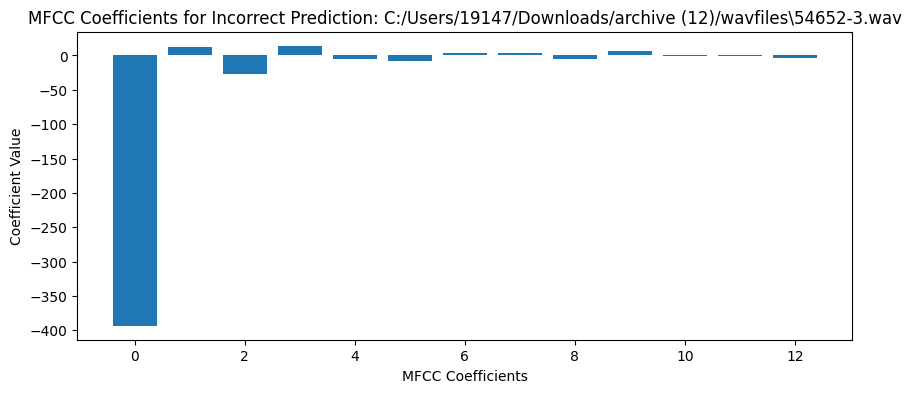

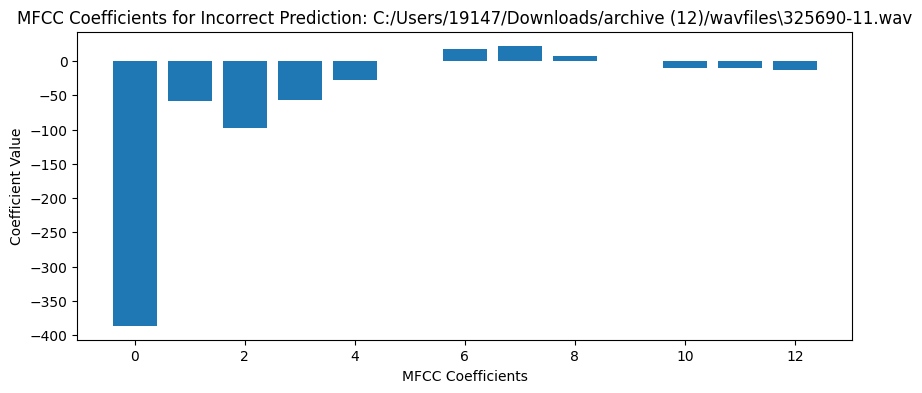

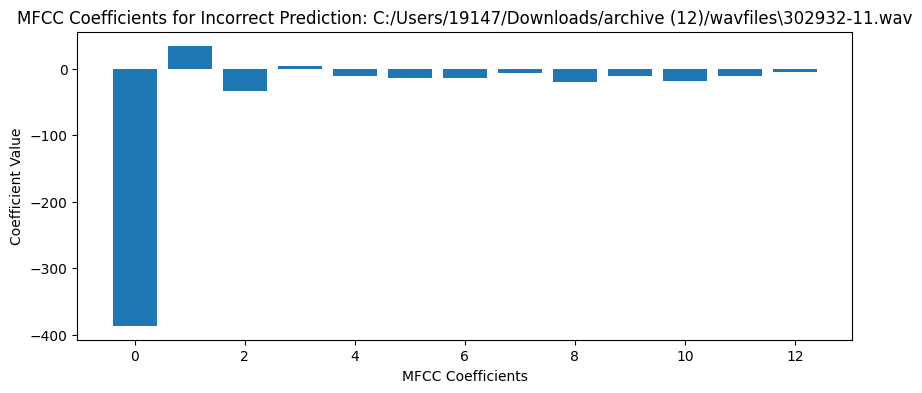

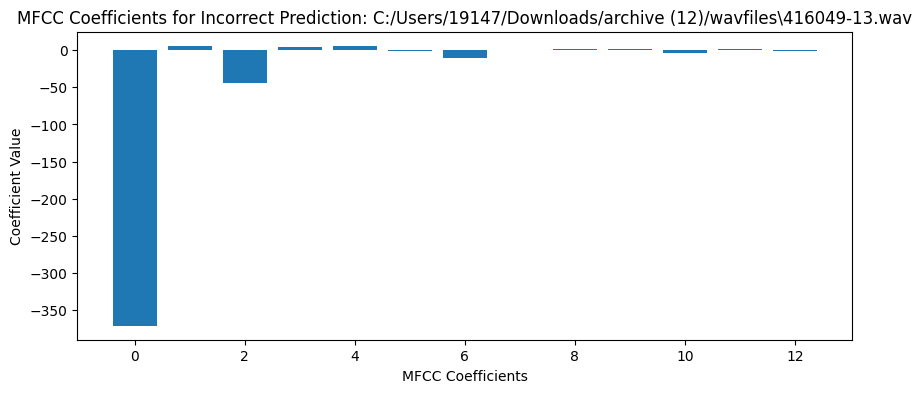

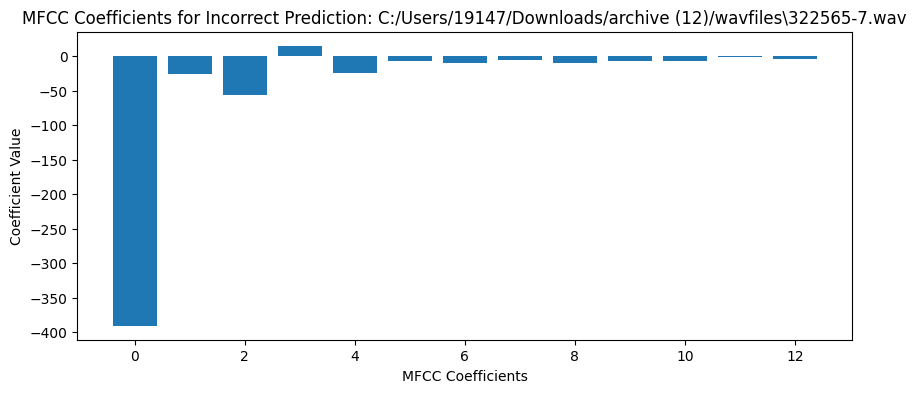

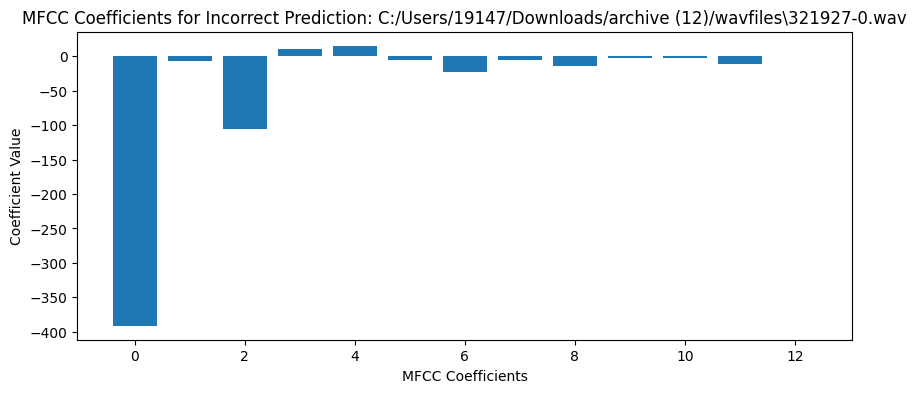

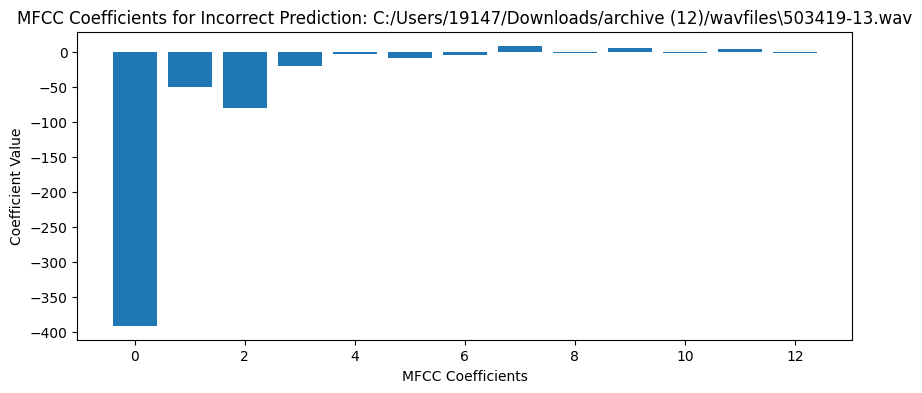

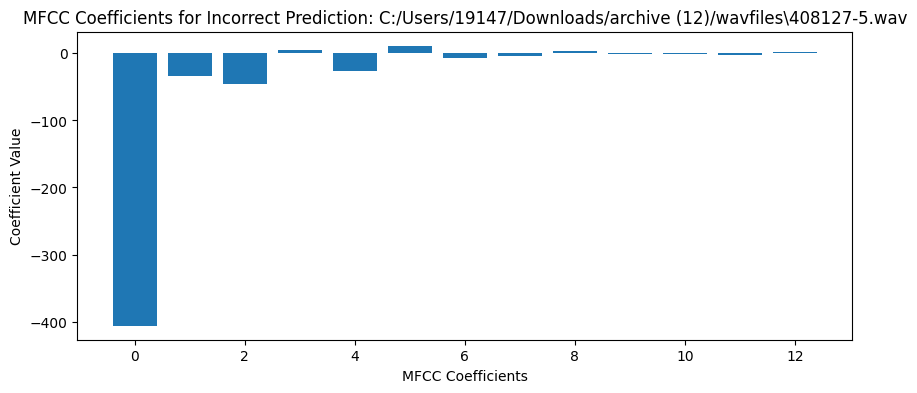

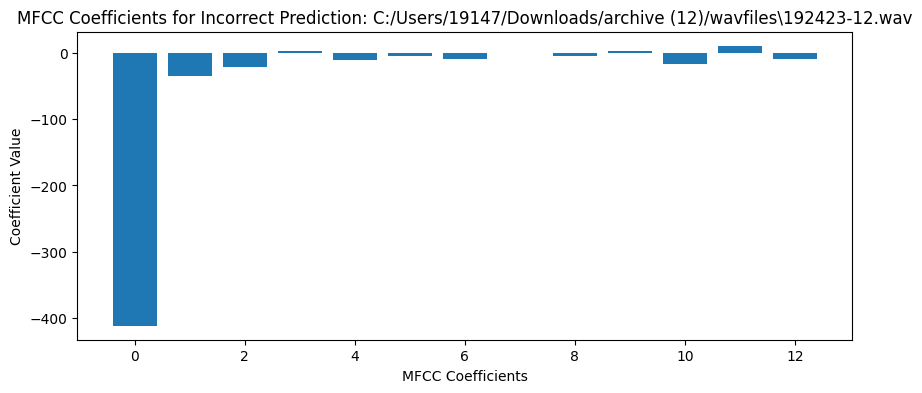

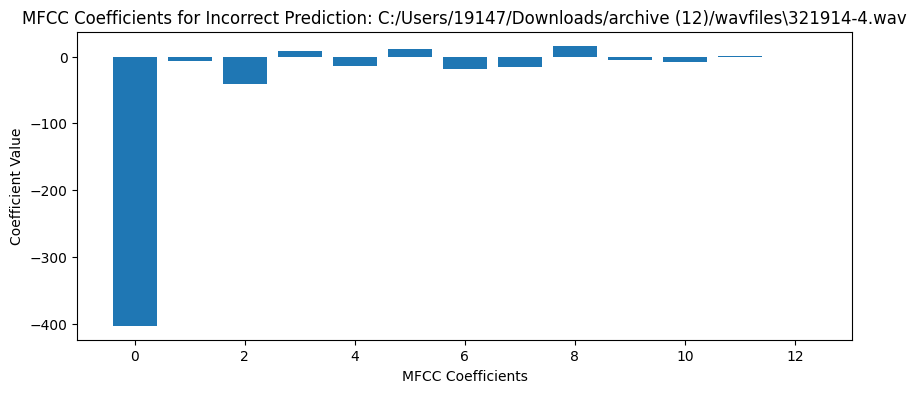

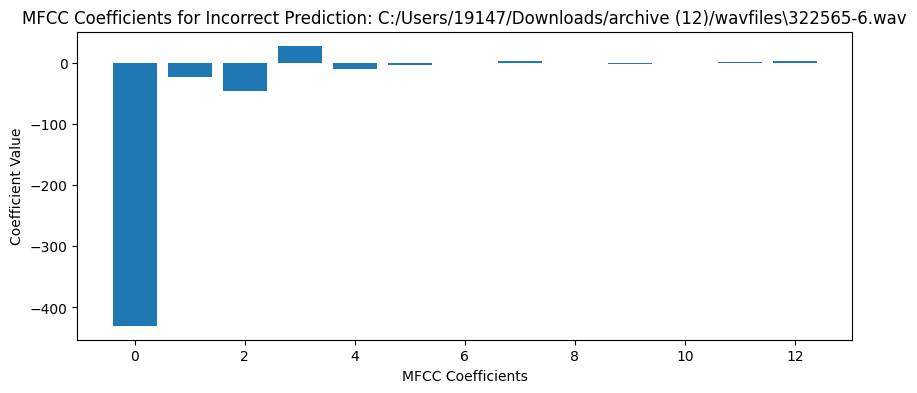

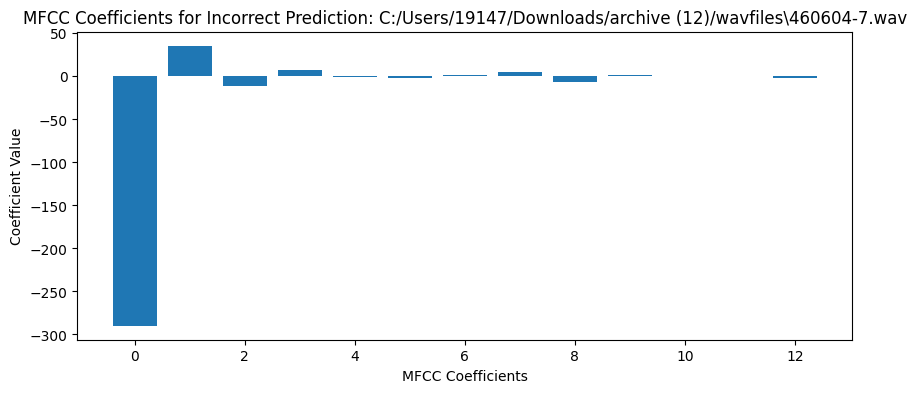

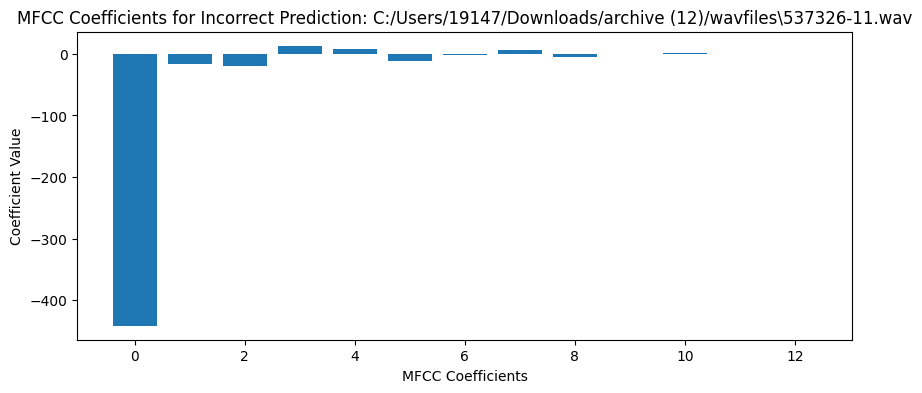

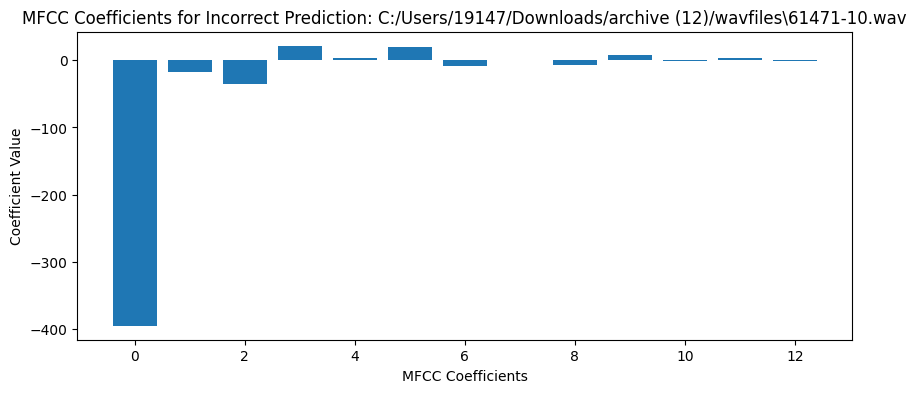

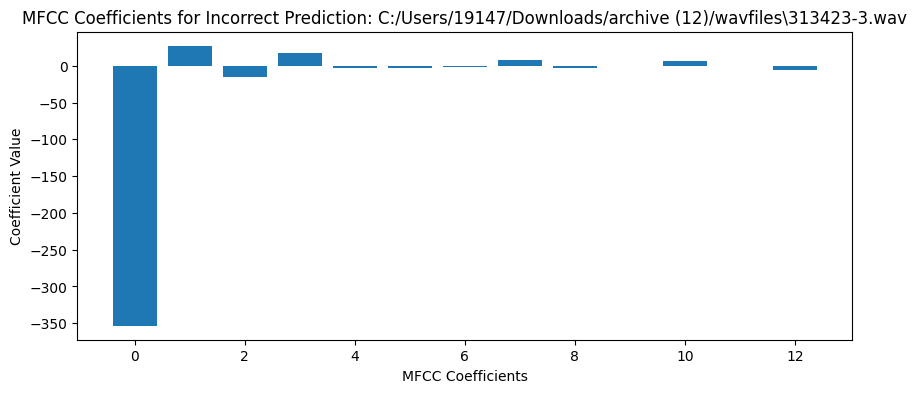

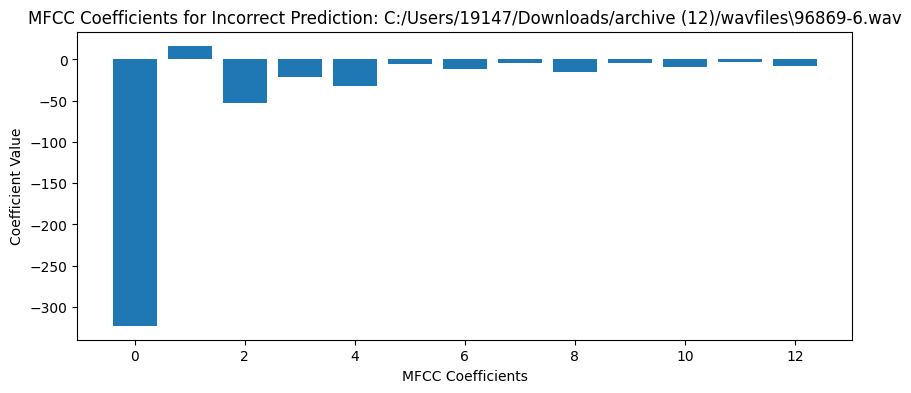

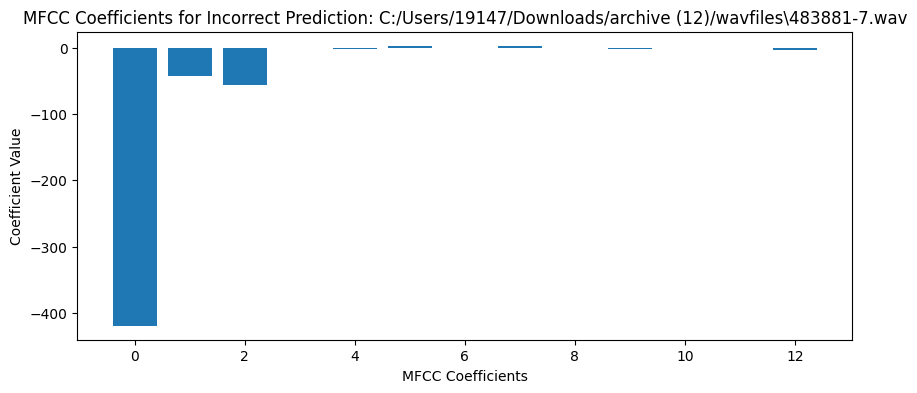

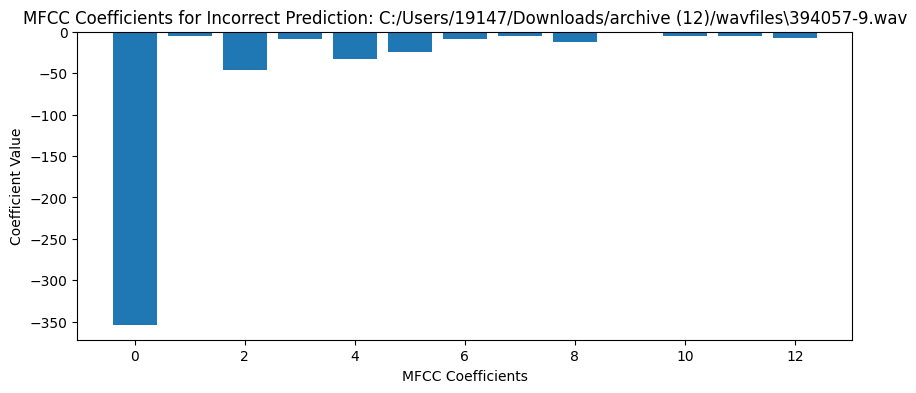

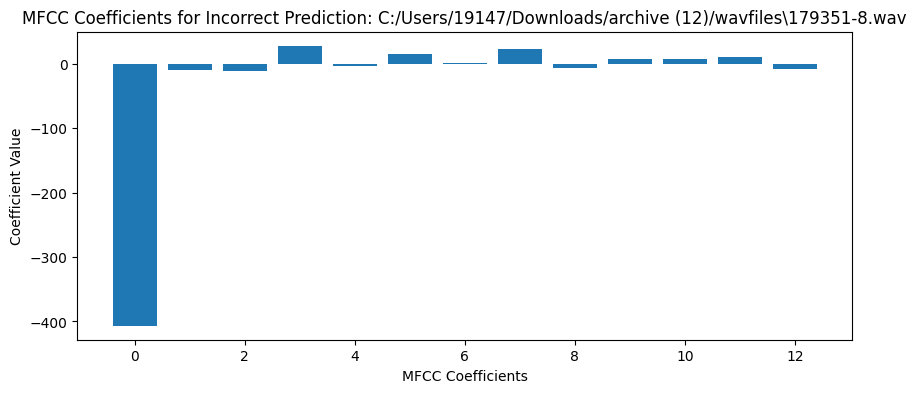

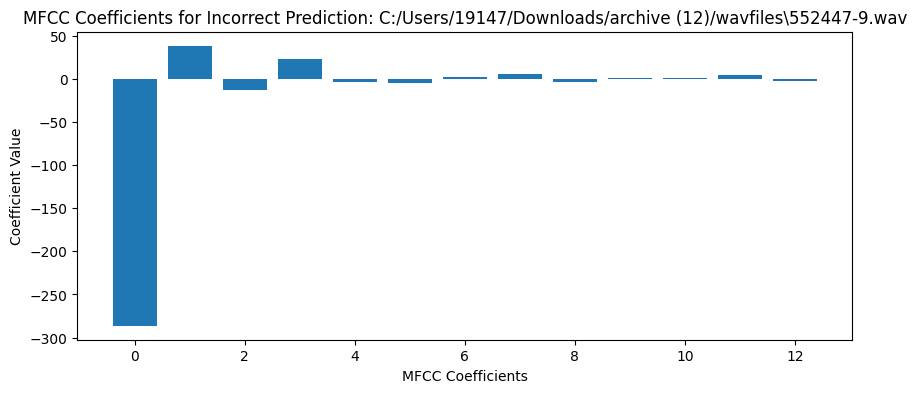

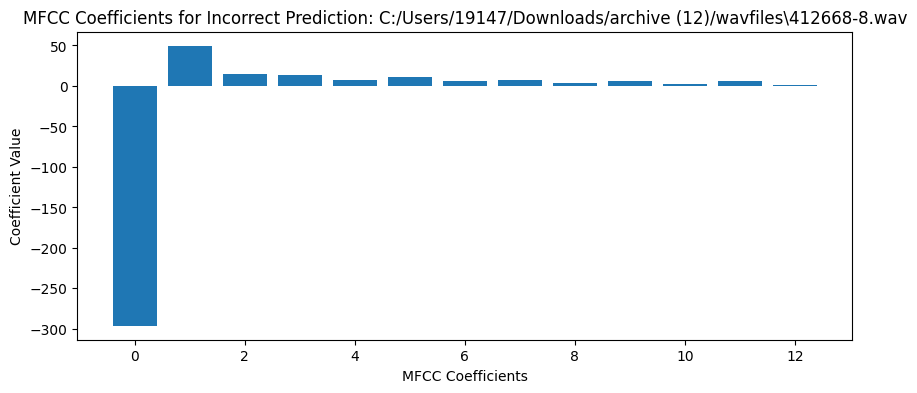

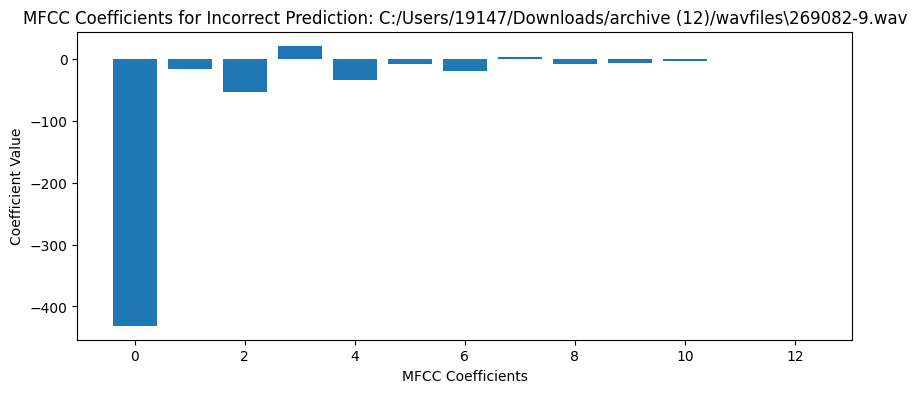

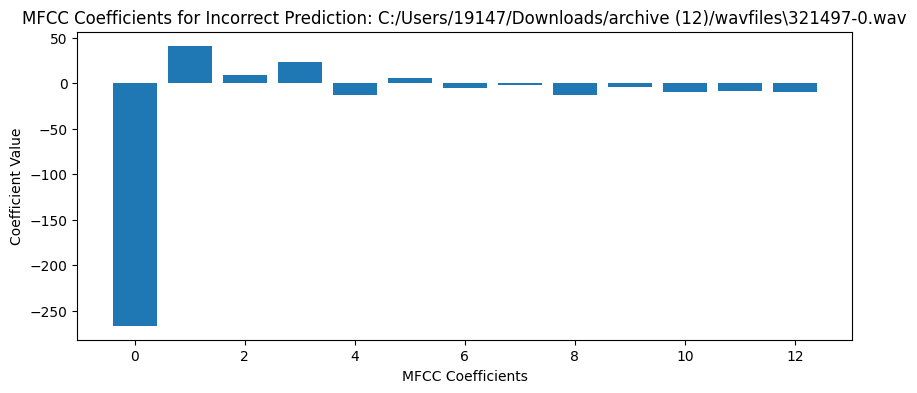

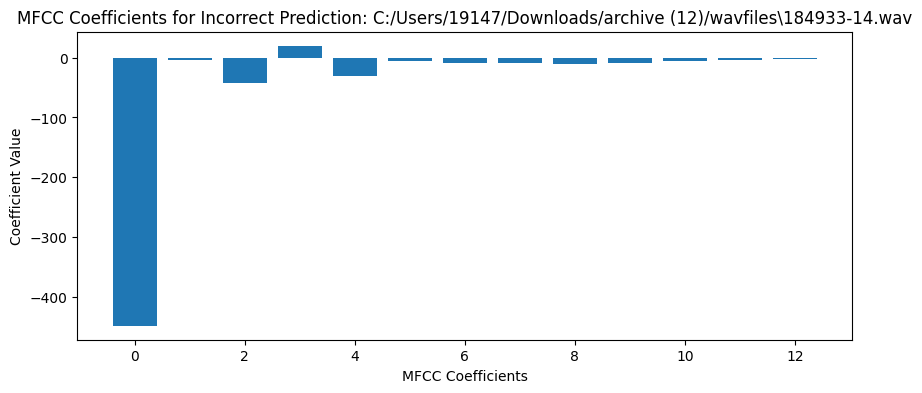

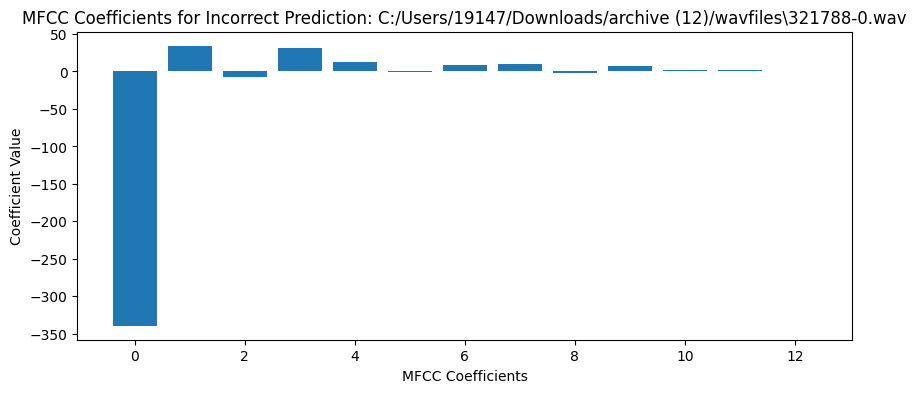

In [17]:
for index in incorrect_indices_mfcc:
    incorrect_mfcc = X_test[index]
    incorrect_file_path = files_test[index]
    plot_title = f'MFCC Coefficients for Incorrect Prediction: {incorrect_file_path}'
    plot_mfcc_coefficients(incorrect_mfcc, plot_title)


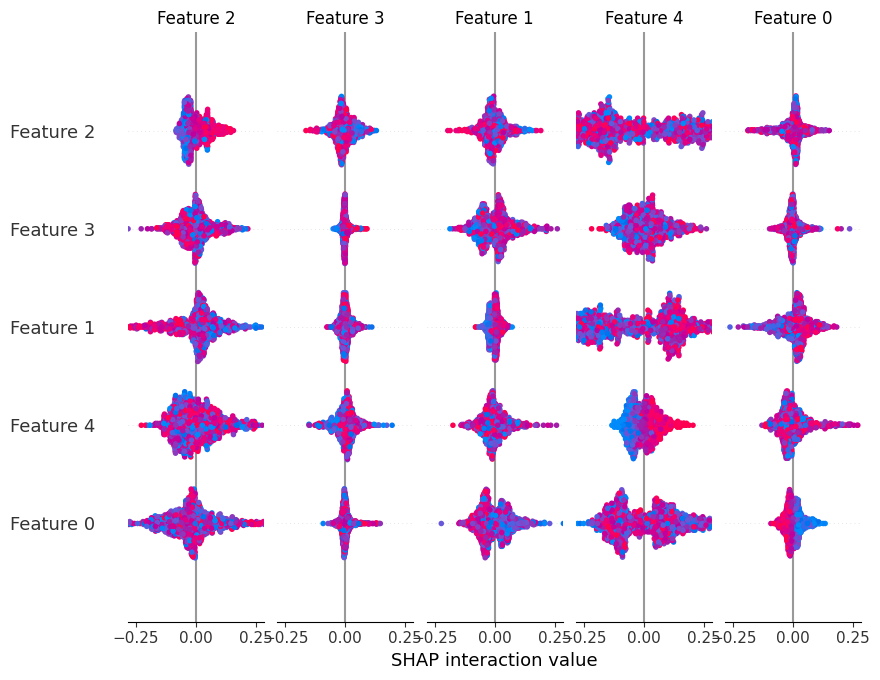

In [19]:
explainer = shap.TreeExplainer(clf_mfcc)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

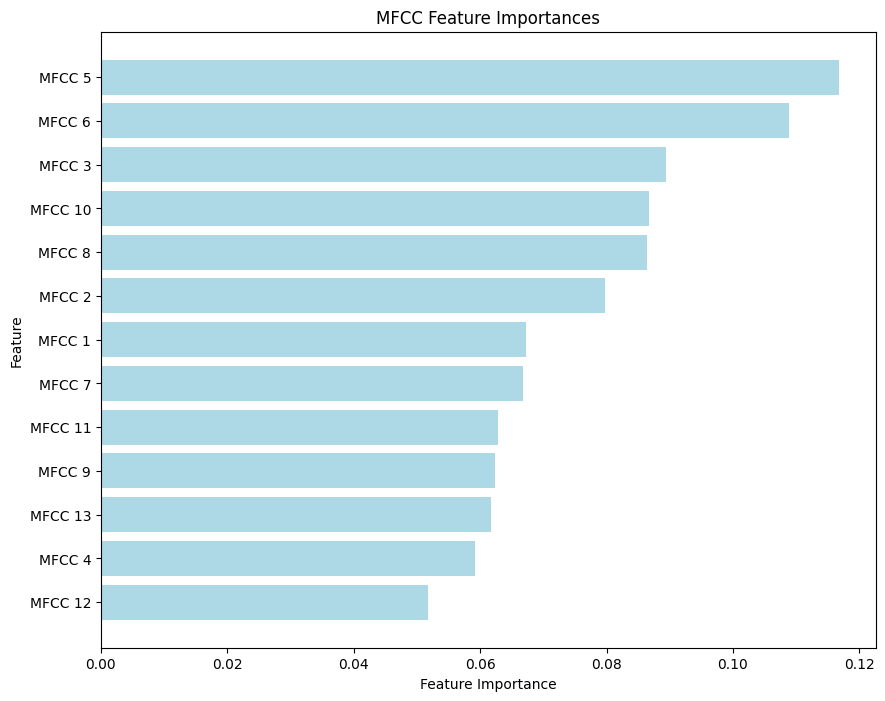

In [17]:
# MFCC features
sorted_idx = clf_mfcc.feature_importances_.argsort()

mfcc_feature_names = [f'MFCC {i+1}' for i in range(len(clf_mfcc.feature_importances_))]

plt.figure(figsize=(10, 8))
plt.barh(range(len(clf_mfcc.feature_importances_[sorted_idx])), clf_mfcc.feature_importances_[sorted_idx], color='lightblue')
plt.yticks(range(len(clf_mfcc.feature_importances_[sorted_idx])), np.array(mfcc_feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("MFCC Feature Importances")
plt.show()
